#### Loading Libraries

In [68]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegressionCV as LogReg
from sklearn import metrics
import matplotlib.pyplot as plt
import gc; gc.enable()
import seaborn as sns
from sklearn.model_selection import KFold
import numpy as np

import warnings
warnings.filterwarnings("ignore")

#### Loading Data

In [69]:
# folder_path = '../input/'
train_identity = pd.read_csv(r'C:\Users\abajp\PycharmProjects\Fraud Detection\ieee-fraud-detection\train_identity.csv')
train_transaction = pd.read_csv(r'C:\Users\abajp\PycharmProjects\Fraud Detection\ieee-fraud-detection\train_transaction.csv')


def combine_data(transaction, identity):
    data = pd.merge(transaction, 
                    identity, 
                    on='TransactionID', 
                    how='left')
    return data


train = combine_data(train_transaction, train_identity)
sample_submission = pd.read_csv('../input/sample_submission.csv', index_col='TransactionID')
# train = train_transaction.copy()
del train_transaction; del train_identity; gc.collect()


6176

In [70]:
t_identity=pd.read_csv(r'C:\Users\abajp\PycharmProjects\Fraud Detection\ieee-fraud-detection\test_identity.csv')
t_transaction=pd.read_csv(r'C:\Users\abajp\PycharmProjects\Fraud Detection\ieee-fraud-detection\test_transaction.csv')

test = combine_data(t_transaction, t_identity)
# train = train_transaction.copy()
del t_transaction; del t_identity; gc.collect()


0

In [71]:

def rename_test_columns(df):
    """
    Renames all columns in the test set by replacing '-' with '_'.
    
    Parameters:
    df (DataFrame): The test DataFrame
    
    Returns:
    DataFrame: Updated DataFrame with renamed columns
    """
    df.columns = [col.replace("-", "_") for col in df.columns]
    return df

# Apply the function to the test set
test = rename_test_columns(test)

# Verify column names
print(test.columns)

Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD',
       'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=433)


In [72]:
def resumetable(df):
    """
    Summarizes a DataFrame by showing data types, missing values, unique values,
    and the first three values for each column. Also calculates entropy for each column.
    """
    print(f"Dataset Shape: {df.shape}")
    
    # Creating a summary DataFrame with column names and data types
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name', 'dtypes']]
    
    # Adding missing value counts and unique value counts
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    
    # Extracting first three values of each column
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values
    
    # Calculating entropy for each column
    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(
            
            stats.entropy(df[name].value_counts(normalize=True), base=2), 2
        )
    
    return summary

def reduce_mem_usage(df, verbose=True):
    """
    Reduces the memory usage of a DataFrame by converting numerical columns to the smallest possible data types.
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    # Calculate initial memory usage in MB
    
    # Iterating through each column to optimize memory usage
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            
            # Downcasting integer columns
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            
            # Downcasting float columns
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    
    end_mem = df.memory_usage().sum() / 1024**2  # Calculate final memory usage in MB
    
    # Print memory usage reduction if verbose is enabled
    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(
            end_mem, 100 * (start_mem - end_mem) / start_mem
        ))
    
    return df

def CalcOutliers(df_num):
    """
    Identifies outliers in a numerical dataset using a 3-standard deviation threshold.
    """
    # Calculating mean and standard deviation of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)
    
    # Setting the cutoff threshold to 3 standard deviations (modifiable)
    cut = data_std * 3
    
    # Defining lower and upper outlier thresholds
    lower, upper = data_mean - cut, data_mean + cut
    
    # Identifying outliers
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]
    
    # Filtering values that are not outliers
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    # Printing outlier statistics
    print('Identified lowest outliers: %d' % len(outliers_lower))
    print('Identified upper outliers: %d' % len(outliers_higher))
    print('Total outlier observations: %d' % len(outliers_total))
    print('Non-outlier observations: %d' % len(outliers_removed))
    print("Total percentage of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4))
    
    return

In [73]:
X_train = reduce_mem_usage(train)
X_test = reduce_mem_usage(test)

Mem. usage decreased to 650.48 Mb (66.8% reduction)
Mem. usage decreased to 565.37 Mb (66.3% reduction)


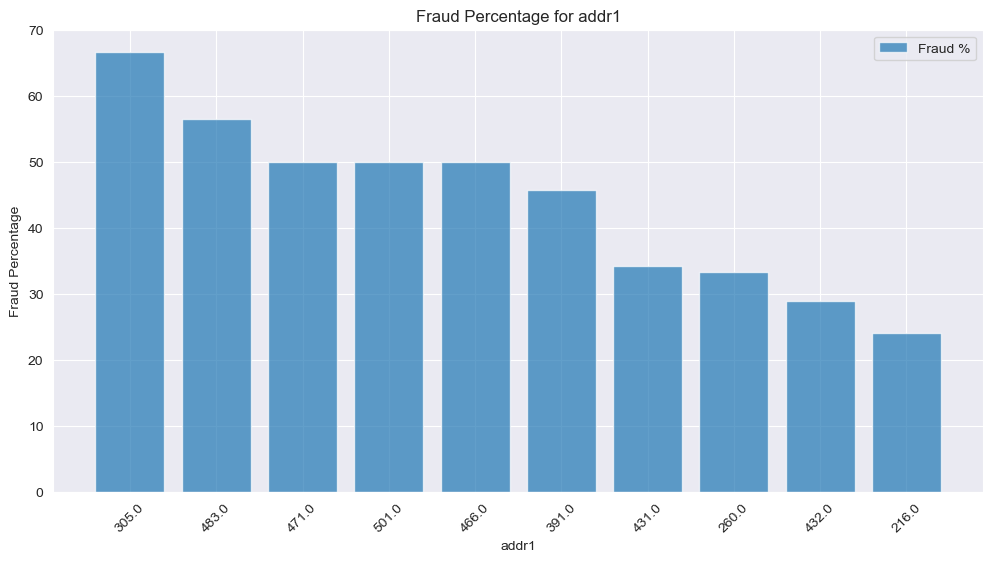

In [74]:
def ploting_cnt_amt(df, col, lim=10):
    """
    Plots fraud percentage and transaction amount for a given column.
    
    Parameters:
        df (DataFrame): The dataset.
        col (str): Column name.
        lim (int): Number of unique values to show.
    """
    df = df.copy()
    
    # Handle missing values
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna('Missing')  # Replace NaNs with a placeholder

    # Convert to string (if categorical)
    if df[col].dtype not in [np.number, np.int64, np.float64]:
        df[col] = df[col].astype(str)

    # Compute fraud percentage per category
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0: 'NoFraud', 1: 'Fraud'}, inplace=True)
    
    # Limit number of categories displayed
    tmp = tmp.sort_values(by='Fraud', ascending=False).head(lim)
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.bar(tmp[col], tmp['Fraud'], alpha=0.7, label='Fraud %')
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel('Fraud Percentage')
    plt.title(f'Fraud Percentage for {col}')
    plt.legend()
    plt.show()
# Example usage: Visualize distribution of 'addr1' column
ploting_cnt_amt(train, 'addr1')


In [75]:
train.shape, test.shape

((590540, 434), (506691, 433))

Knowing the data


Target Distribution


In [76]:
import gc
target = 'isFraud'
_id = 'TransactionID'
def data_prep(data, target, _id, isTest=0):
    """
    Prepares the dataset for training or testing by selecting relevant columns.
    
    Parameters:
    data (DataFrame): The dataset to be processed.
    isTest (int): Flag to indicate whether the dataset is a test set (default is 0).
    
    Returns:
    Tuple: (processed DataFrame, list of kept columns, list of used columns)
    """
    # Select columns excluding target and ID
    keep_cols = [col for col in data.columns.tolist() if col not in [target, _id]]
    
    # If not a test set, include the target variable
    if not isTest:
        keep_cols += [target]
    
    # Used columns exclude target and ID (assumed to be the columns in the test set)
    used_cols = [col for col in keep_cols if col in data.columns]

    return data[keep_cols].copy(), keep_cols, used_cols

# Prepare training data
train, keep_cols, used_cols = data_prep(train, target, _id)

# Extract test set transaction IDs
test_id = test['TransactionID']

# Ensure only columns from the test dataset are selected
test = test[[col for col in used_cols if col in test.columns]]

# Run garbage collection to free memory
gc.collect()



3825

In [77]:
train.shape, test.shape

((590540, 433), (506691, 432))

#### Instantiate functions We'll be using later
##### Monotonic Binning
##### Categorical Binning
##### Information Value

In [78]:
# Define the maximum number of bins for binning
max_bin = 20
# Define a fallback minimum number of bins in case of errors
force_bin = 3

# Function to perform monotonic binning on a numerical variable
def mono_bin(Y, X, n=max_bin):
    """
    Perform monotonic binning for a numerical feature (X) with respect to the target variable (Y).
    This function divides X into bins using quantiles while ensuring a monotonic relationship with Y.
    
    Parameters:
    Y (Series): Target variable (binary)
    X (Series): Numeric feature to be binned
    n (int): Maximum number of bins
    
    Returns:
    DataFrame: Binned data with calculated WOE (Weight of Evidence) and IV (Information Value)
    """
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[df1.X.isnull()]  # Store missing values separately
    notmiss = df1[df1.X.notnull()]  # Keep non-missing values
    r = 0

    # Iteratively reduce bins until a monotonic relationship is found
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1  # Reduce the bin count and try again
        except Exception:
            n = n - 1  # If an exception occurs, reduce bin count and retry

    # If only one bin remains, force a predefined number of bins
    if len(d2) == 1:
        n = force_bin
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1] - (bins[1] / 2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins), include_lowest=True)})
        d2 = d1.groupby('Bucket', as_index=True)

    # Create bin summary statistics
    d3 = pd.DataFrame({}, index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y  # Count of target=1
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y  # Count of target=0
    d3 = d3.reset_index(drop=True)

    # Append missing value bin if any
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE': np.nan}, index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4, ignore_index=True)

    # Compute WOE and IV
    d3["EVENT_RATE"] = d3.EVENT / d3.sum().EVENT
    d3["NON_EVENT_RATE"] = d3.NONEVENT / d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.EVENT_RATE / d3.NON_EVENT_RATE)
    d3["IV"] = (d3.EVENT_RATE - d3.NON_EVENT_RATE) * np.log(d3.EVENT_RATE / d3.NON_EVENT_RATE)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME', 'MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'WOE', 'IV']]
    
    # Replace infinite values with zero and sum IV
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return d3

# Function to perform binning for categorical variables
def char_bin(Y, X):
    """
    Perform binning for categorical variables with respect to the target variable.
    
    Parameters:
    Y (Series): Target variable (binary)
    X (Series): Categorical feature
    
    Returns:
    DataFrame: Binned data with calculated WOE and IV
    """
    df1 = pd.DataFrame({"X": X, "Y": Y})
    df2 = df1.groupby('X', as_index=True)

    d3 = pd.DataFrame({}, index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.groups
    d3["MAX_VALUE"] = df2.groups
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    d3["EVENT_RATE"] = d3.EVENT / d3.sum().EVENT
    d3["NON_EVENT_RATE"] = d3.NONEVENT / d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.EVENT_RATE / d3.NON_EVENT_RATE)
    d3["IV"] = (d3.EVENT_RATE - d3.NON_EVENT_RATE) * np.log(d3.EVENT_RATE / d3.NON_EVENT_RATE)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME', 'MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'WOE', 'IV']]
    
    # Replace infinite values and sum IV
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)

    return d3

# Function to calculate Information Value (IV) for all variables in a dataset
def data_vars(df1, target):
    """
    Computes Information Value (IV) for all variables in a given dataset with respect to the target variable.
    
    Parameters:
    df1 (DataFrame): The input dataset
    target (str): The name of the target variable
    
    Returns:
    Tuple: IV DataFrame with detailed binning statistics and summary IV strength classification
    """
    # Extract variable names from function call
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]

    x = df1.dtypes.index
    count = -1

    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count += 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count += 1

            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv, ignore_index=True)

    iv = pd.DataFrame({'IV': iv_df.groupby('VAR_NAME').IV.max()})

    # Categorize IV strength
    iv['STRENGTH'] = 'useless'
    iv.loc[iv['IV'] >= 0.02, 'STRENGTH'] = 'weak'
    iv.loc[iv['IV'] >= 0.1, 'STRENGTH'] = 'medium'
    iv.loc[iv['IV'] >= 0.3, 'STRENGTH'] = 'strong'
    iv.loc[iv['IV'] > 0.5, 'STRENGTH'] = 'suspicious'

    iv = iv.reset_index()
    
    return iv_df, iv

In [79]:
train.shape, test.shape

((590540, 433), (506691, 432))

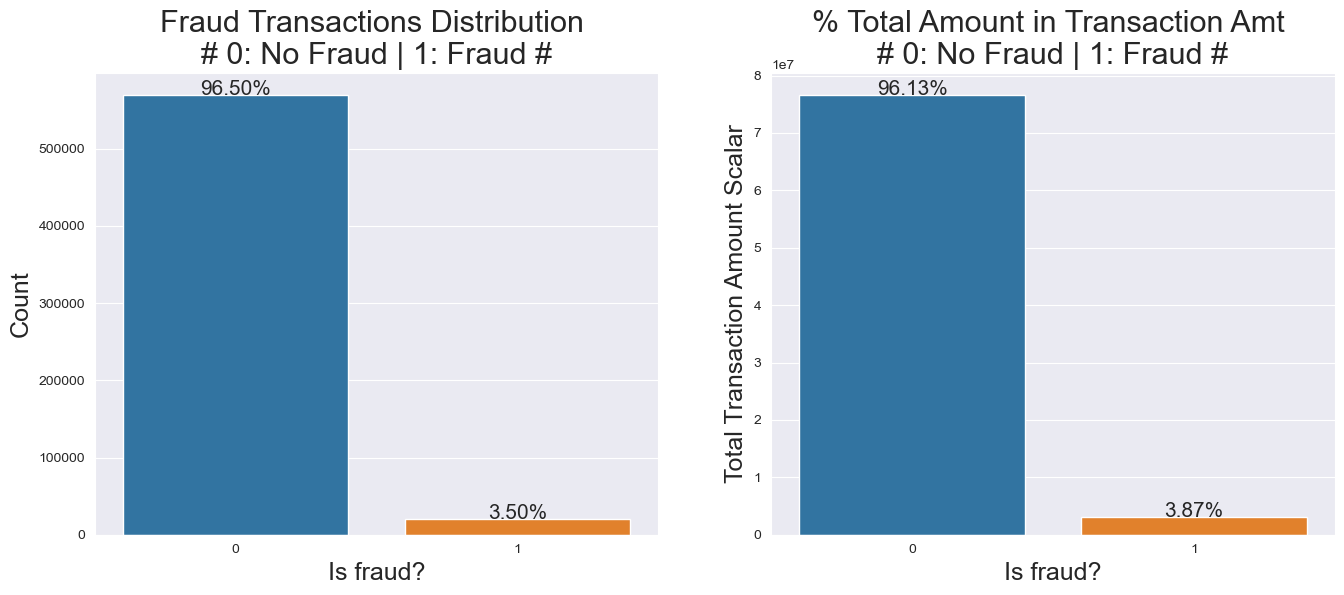

In [80]:
train['TransactionAmt'] = train['TransactionAmt'].astype(float)
total = len(train)
total_amt = train.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize=(16,6))

plt.subplot(121)
g = sns.countplot(x='isFraud', data=train, )
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g.set_xlabel("Is fraud?", fontsize=18)
g.set_ylabel('Count', fontsize=18)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 

perc_amt = (train.groupby(['isFraud'])['TransactionAmt'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
g1 = sns.barplot(x='isFraud', y='TransactionAmt',  dodge=True, data=perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g1.set_xlabel("Is fraud?", fontsize=18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize=18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt * 100),
            ha="center", fontsize=15) 
    
plt.show()

In [81]:
train.shape, test.shape

((590540, 433), (506691, 432))

#### We have 3.5% of Fraud transactions in our dataset.
#### I think that it would be interesting to see if the amount percentual is higher or lower than 3.5% of total. I will see it later.
#### We have the same % when considering the Total Transactions Amount by Fraud and No Fraud.

In [82]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import StandardScaler  # Example scaler


class BaseTransformer(BaseEstimator, TransformerMixin):
    """
    A base transformer class for sklearn pipelines.
    
    Parameters:
    - columns (list): List of columns to transform.
    - suffix (str): Suffix for transformed column names.
    - scaler (object): Scaler object to apply transformations.
    """
    def __init__(self, columns=None, suffix='_base', scaler=None):
        self.columns = columns
        self.suffix = suffix
        self.scaler = scaler if scaler else StandardScaler()
    
    def fit(self, X, y=None):
        """
        Fits the transformer on the given dataset.
        """
        if self.columns is None:
            self.columns = X.columns.tolist()
        self.scaler.fit(X[self.columns])
        return self  # Return self for sklearn compatibility
    
    def transform(self, X, y=None):
        """
        Transforms the dataset using the fitted scaler.
        """
        X_transformed = X.copy()
        X_transformed[self.columns] = self.scaler.transform(X[self.columns])
        return X_transformed
    
    def fit_transform(self, X, y=None):
        """
        Fits and transforms the dataset.
        """
        return self.fit(X, y).transform(X, y)
    
    def save(self, path):
        """
        Saves the transformer state to a file.
        """
        joblib.dump((self.columns, self.suffix, self.scaler), path)
    
    def load(self, path):
        """
        Loads the transformer state from a file.
        """
        self.columns, self.suffix, self.scaler = joblib.load(path)


# Seeing the Quantiles of Fraud and No Fraud Transactions

In [83]:
print(pd.concat([train[train['isFraud'] == 1]['TransactionAmt']\
                 .quantile([.01, .1, .25, .5, .75, .9, .99])\
                 .reset_index(), 
                 train[train['isFraud'] == 0]['TransactionAmt']\
                 .quantile([.01, .1, .25, .5, .75, .9, .99])\
                 .reset_index()],
                axis=1, keys=['Fraud', "No Fraud"]))

  Fraud                No Fraud               
  index TransactionAmt    index TransactionAmt
0  0.01       6.739453     0.01       9.511875
1  0.10      18.937500     0.10      26.312500
2  0.25      35.031250     0.25      43.968750
3  0.50      75.000000     0.50      68.500000
4  0.75     161.000000     0.75     120.000000
5  0.90     335.000000     0.90     267.100000
6  0.99     994.000000     0.99    1104.000000


# Now, let's known the Product Feature
- Distribution Products
- Distribution of Frauds by Product
- Has Difference between Transaction Amounts in Products?

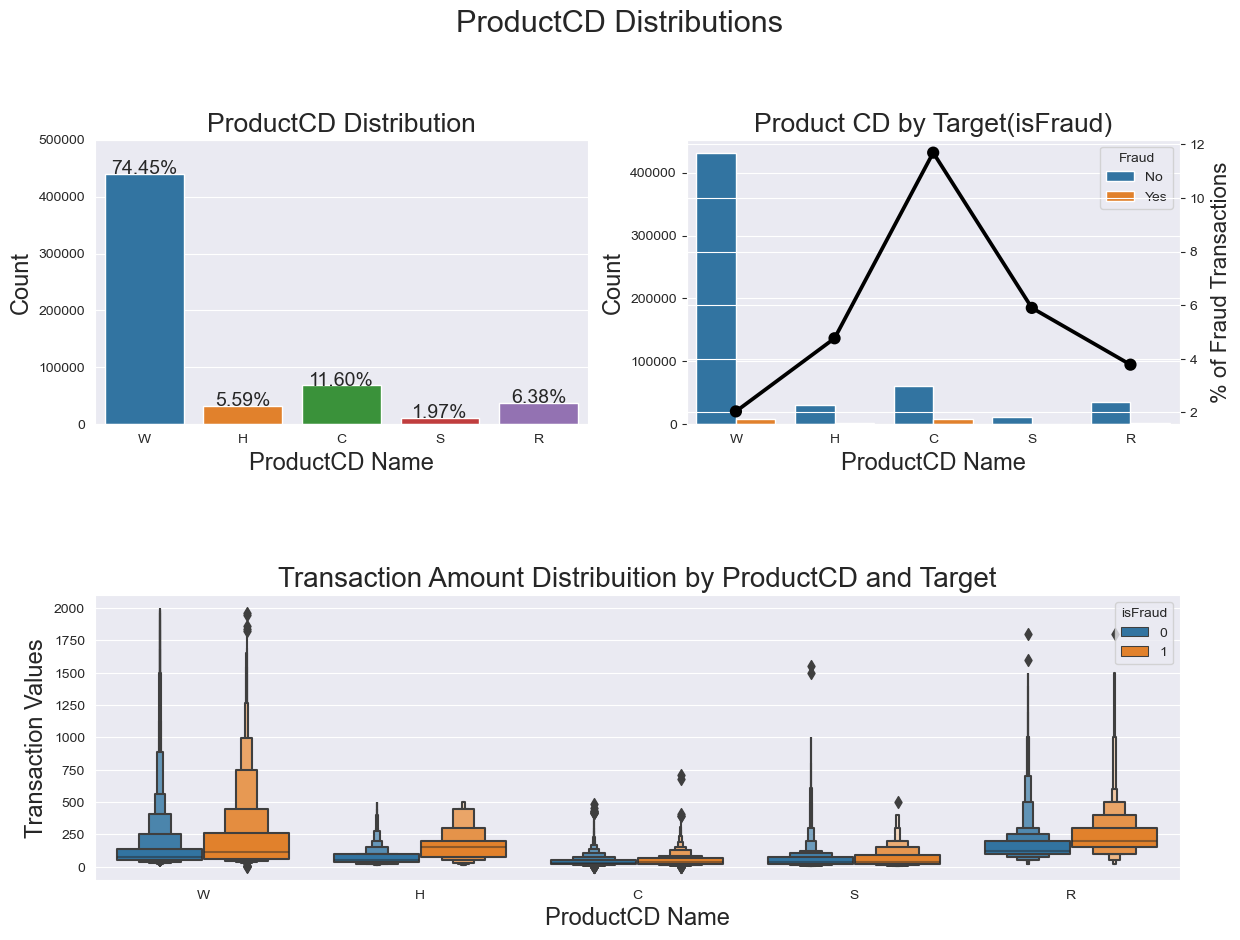

In [84]:
tmp = pd.crosstab(train['ProductCD'], train['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('ProductCD Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='ProductCD', data=train)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

g.set_title("ProductCD Distribution", fontsize=19)
g.set_xlabel("ProductCD Name", fontsize=17)
g.set_ylabel("Count", fontsize=17)
g.set_ylim(0,500000)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(222)
g1 = sns.countplot(x='ProductCD', hue='isFraud', data=train)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='ProductCD', y='Fraud', data=tmp, color='black', order=['W', 'H',"C", "S", "R"], legend=False)
gt.set_ylabel("% of Fraud Transactions", fontsize=16)

g1.set_title("Product CD by Target(isFraud)", fontsize=19)
g1.set_xlabel("ProductCD Name", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

plt.subplot(212)
g3 = sns.boxenplot(x='ProductCD', y='TransactionAmt', hue='isFraud', 
              data=train[train['TransactionAmt'] <= 2000] )
g3.set_title("Transaction Amount Distribuition by ProductCD and Target", fontsize=20)
g3.set_xlabel("ProductCD Name", fontsize=17)
g3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()


In [85]:
train.shape, test.shape

((590540, 433), (506691, 432))

#### W, C and R are the most frequent values.
 We can note that in W, H and R the distribution of Fraud values are slightly higher than the Non-Fraud Transactions
 
# Let's look at card features

In [86]:
print("Card Features Quantiles: ")
print(train[['card1', 'card2', 'card3', 'card5']].quantile([0.01, .025, .1, .25, .5, .75, .975, .99]))

Card Features Quantiles: 
         card1  card2  card3  card5
0.010   1338.0  100.0  144.0  102.0
0.025   1675.0  111.0  150.0  102.0
0.100   2803.0  111.0  150.0  126.0
0.250   6019.0  214.0  150.0  166.0
0.500   9678.0  361.0  150.0  226.0
0.750  14184.0  512.0  150.0  226.0
0.975  18018.0  583.0  185.0  226.0
0.990  18238.0  583.0  185.0  226.0


We can see that Card 1 and Card 2 has a large distribution of values, so maybe it will be better to get the log of these columns

In [87]:
train.loc[train.card3.isin(train.card3.value_counts()[train.card3.value_counts() < 200].index), 'card3'] = "Others"
train.loc[train.card5.isin(train.card5.value_counts()[train.card5.value_counts() < 300].index), 'card5'] = "Others"

# Let's see the distribution of card1 and card2

In [88]:
print("Card Features Quantiles: ")
print(train[['addr1', 'addr2']].quantile([0.01, .025, .1, .25, .5, .75, .90,.975, .99]))

Card Features Quantiles: 
       addr1  addr2
0.010  123.0   87.0
0.025  123.0   87.0
0.100  177.0   87.0
0.250  204.0   87.0
0.500  299.0   87.0
0.750  330.0   87.0
0.900  441.0   87.0
0.975  498.0   87.0
0.990  512.0   87.0


In [89]:
train.loc[train.addr1.isin(train.addr1.value_counts()[train.addr1.value_counts() <= 5000 ].index), 'addr1'] = "Others"
train.loc[train.addr2.isin(train.addr2.value_counts()[train.addr2.value_counts() <= 50 ].index), 'addr2'] = "Others"

# Let's examine the relationship between emaildomain and fraud

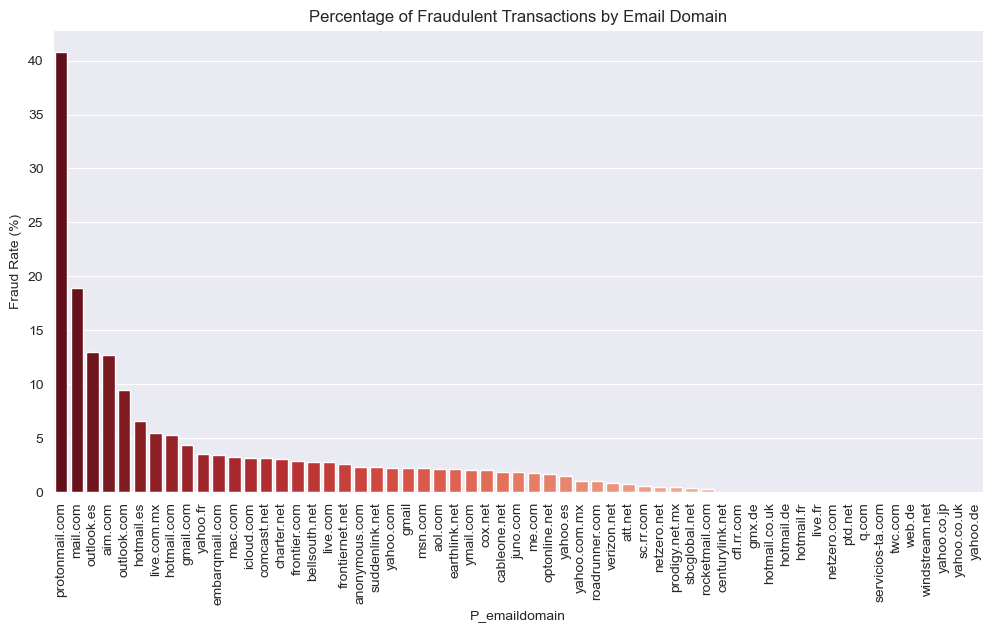

In [90]:
# Group by P_emaildomain and count fraudulent transactions
fraud_counts = train[train['isFraud'] == 1].groupby('P_emaildomain').size()

# Group by P_emaildomain and count total transactions
total_counts = train.groupby('P_emaildomain').size()

# Calculate fraud percentage
fraud_percentage = (fraud_counts / total_counts) * 100

# Convert to DataFrame for easier plotting
fraud_df = fraud_percentage.reset_index()
fraud_df.columns = ['P_emaildomain', 'Fraud_Percentage']

# Sort by fraud percentage
fraud_df = fraud_df.sort_values(by="Fraud_Percentage", ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=fraud_df, x="P_emaildomain", y="Fraud_Percentage", palette="Reds_r")

# Rotate x-axis labels for readability
plt.xticks(rotation=90)

# Labels and title
plt.xlabel("P_emaildomain")
plt.ylabel("Fraud Rate (%)")
plt.title("Percentage of Fraudulent Transactions by Email Domain")

# Show the plot
plt.show()


In [91]:
# Now let's do the same for R_emaildomain

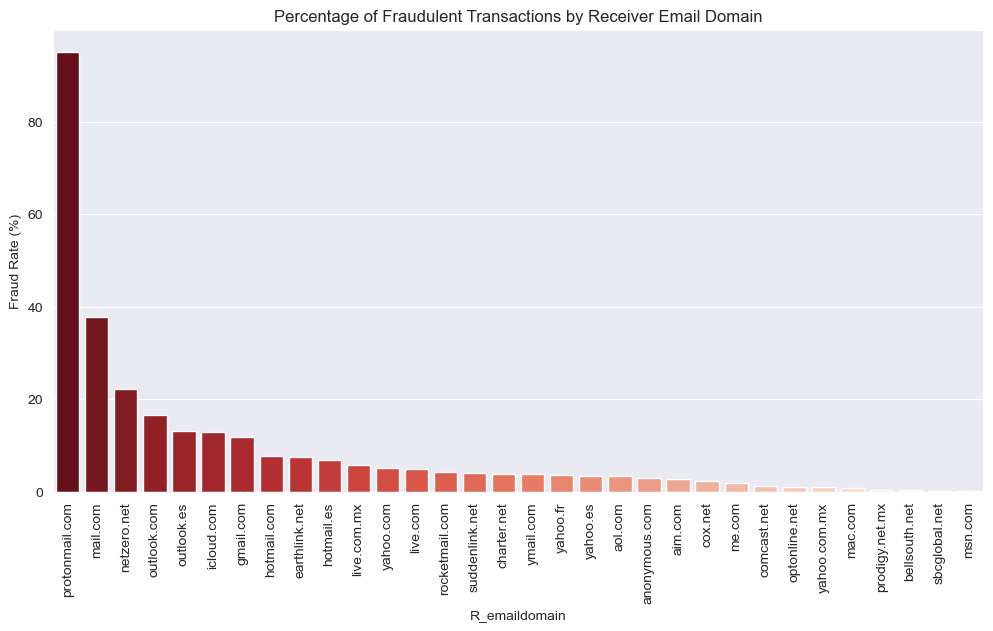

In [92]:
# Count fraudulent transactions per R_emaildomain
fraud_counts = train[train['isFraud'] == 1].groupby('R_emaildomain').size()

# Count total transactions per R_emaildomain
total_counts = train.groupby('R_emaildomain').size()

# Calculate fraud percentage
fraud_percentage = (fraud_counts / total_counts) * 100

# Convert to DataFrame
fraud_df = fraud_percentage.reset_index()
fraud_df.columns = ['R_emaildomain', 'Fraud_Percentage']

# Remove NaN values (if any)
fraud_df = fraud_df.dropna()

# Sort by fraud percentage
fraud_df = fraud_df.sort_values(by="Fraud_Percentage", ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=fraud_df, x="R_emaildomain", y="Fraud_Percentage", palette="Reds_r")

# Rotate x-axis labels for readability
plt.xticks(rotation=90)

# Labels and title
plt.xlabel("R_emaildomain")
plt.ylabel("Fraud Rate (%)")
plt.title("Percentage of Fraudulent Transactions by Receiver Email Domain")

# Show the plot
plt.show()

In [93]:
### Seems like the email domain is a good feature to use, but I think we should create an encoding so we can try a variety of models on it if need be
### Furthermore, target encoding them together can allow us to capture feature interactions between the two variables

def target_encode(train, test, cat_col, target, smoothing=5, drop_original=True):
    """
    Perform target encoding on a categorical column and optionally drop the original column.
    
    Parameters:
    - train (DataFrame): Training dataset
    - test (DataFrame): Test dataset
    - cat_col (str): Categorical column to encode
    - target (str): Target variable (e.g., 'isFraud')
    - smoothing (int): Smoothing factor to avoid overfitting on small categories
    - drop_original (bool): Whether to drop the original categorical column after encoding

    Returns:
    - train DataFrame with encoded column
    - test DataFrame with encoded column
    """
    # Compute overall mean fraud rate
    overall_mean = train[target].mean()
    
    # Compute category mean and count
    category_stats = train.groupby(cat_col)[target].agg(['mean', 'count'])
    mean_col, count_col = category_stats['mean'], category_stats['count']
    
    # Apply smoothing to avoid overfitting for low-count categories
    smooth_enc = (mean_col * count_col + overall_mean * smoothing) / (count_col + smoothing)
    
    # Map encoding to train and test sets
    enc_col = cat_col + "_enc"
    train[enc_col] = train[cat_col].map(smooth_enc)
    test[enc_col] = test[cat_col].map(smooth_enc).fillna(overall_mean)  # Fill unseen categories
    
    # Drop the original column if specified
    if drop_original:
        train.drop(columns=[cat_col], inplace=True)
        test.drop(columns=[cat_col], inplace=True)

    return train, test

# Create a combined P_R_emaildomain feature
train["P_R_emaildomain"] = train["P_emaildomain"].astype(str) + "_" + train["R_emaildomain"].astype(str)
test["P_R_emaildomain"] = test["P_emaildomain"].astype(str) + "_" + test["R_emaildomain"].astype(str)

# Apply target encoding with automatic column dropping
train, test = target_encode(train, test, "P_R_emaildomain", "isFraud", drop_original=True)

# Original categorical columns are automatically dropped


# Examining Anonymized columns C1 to C14

In [94]:
# Define C-columns
c_cols = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
          'C9', 'C10', 'C11', 'C12', 'C13', 'C14']

# Summary statistics for train
train[c_cols].describe()

# Summary statistics for test
test[c_cols].describe()

# Handle rare values in both train and test
threshold = 400  # Frequency cutoff

for col in c_cols:
    # Find rare values in train
    rare_values = train[col].value_counts()[train[col].value_counts() <= threshold].index
    
    # Replace rare values with "Others" in both train and test
    train.loc[train[col].isin(rare_values), col] = "Others"
    test.loc[test[col].isin(rare_values), col] = "Others"


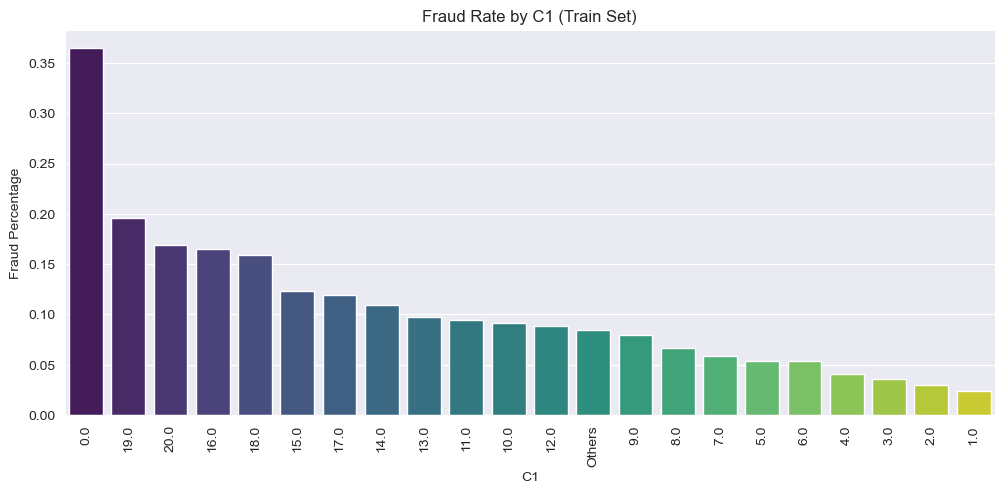

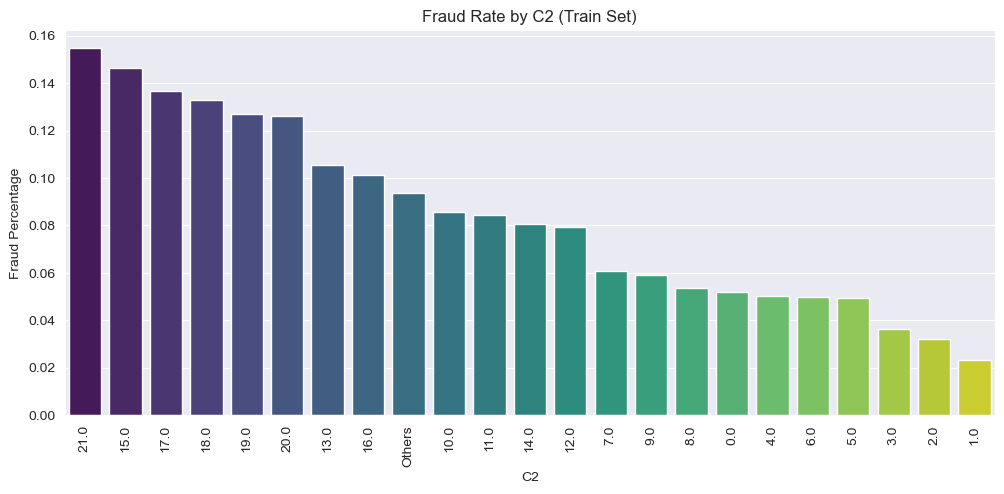

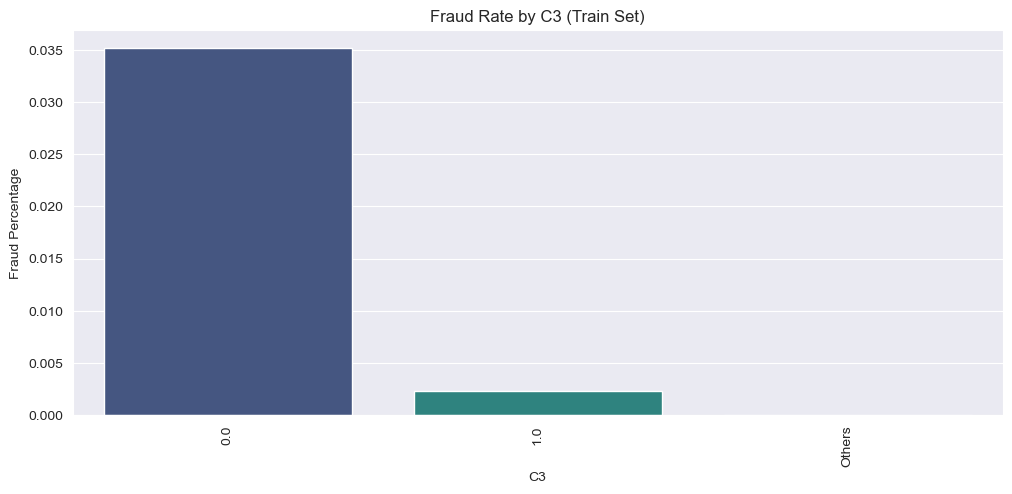

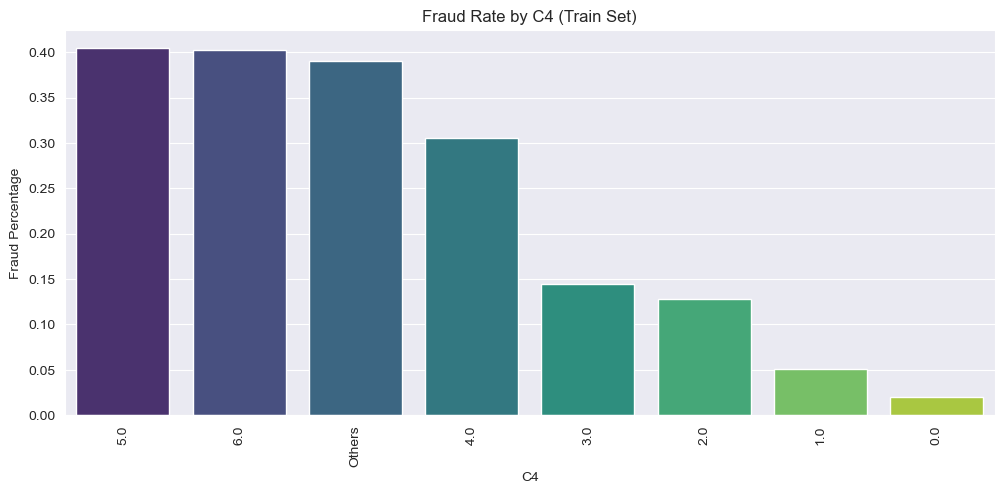

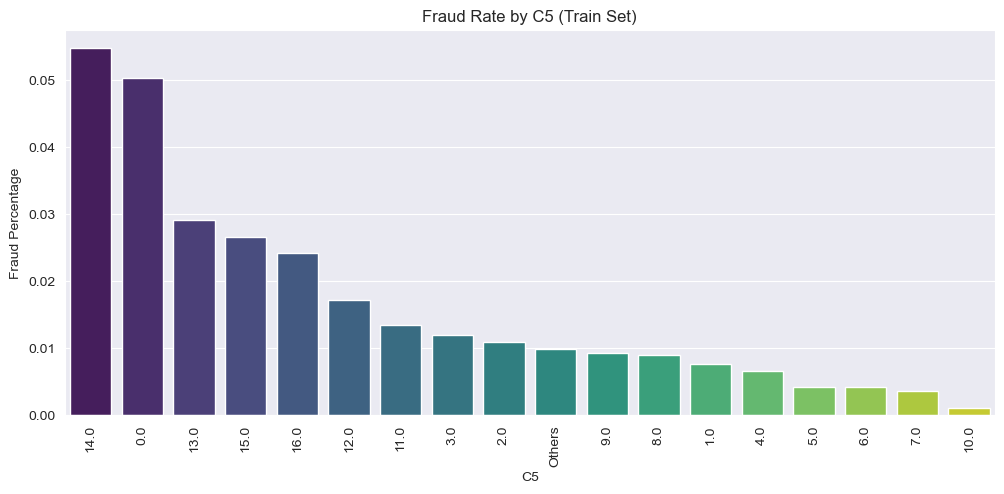

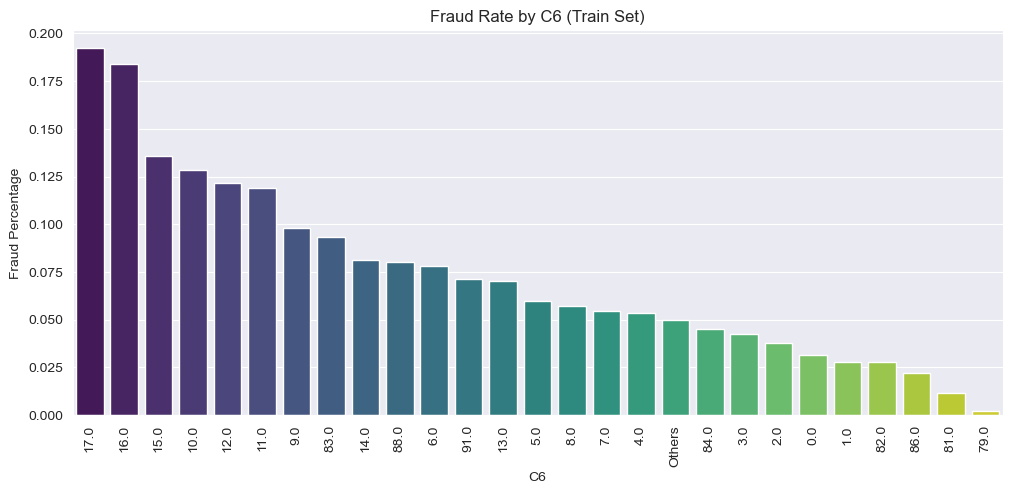

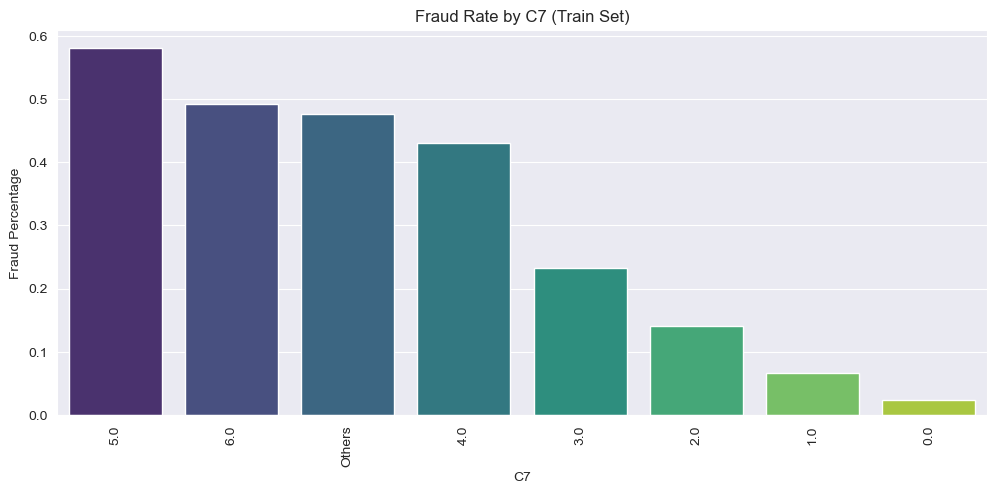

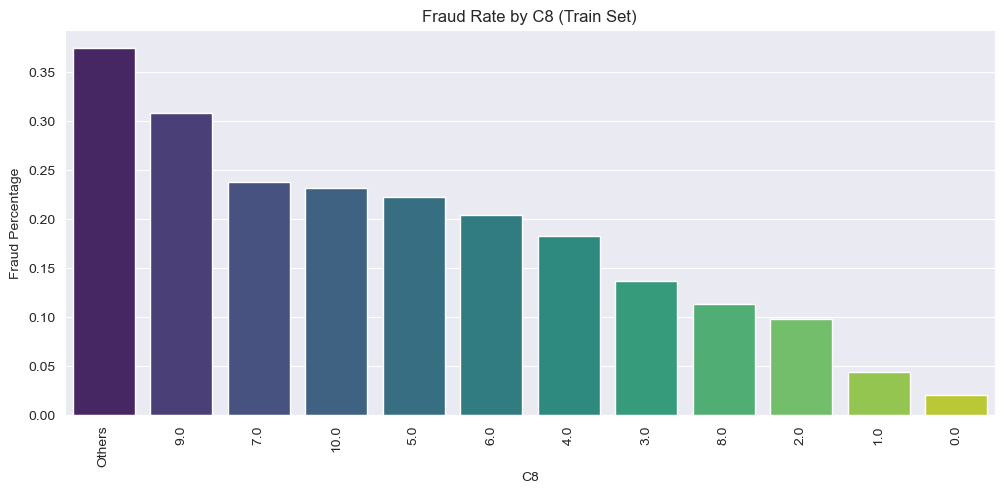

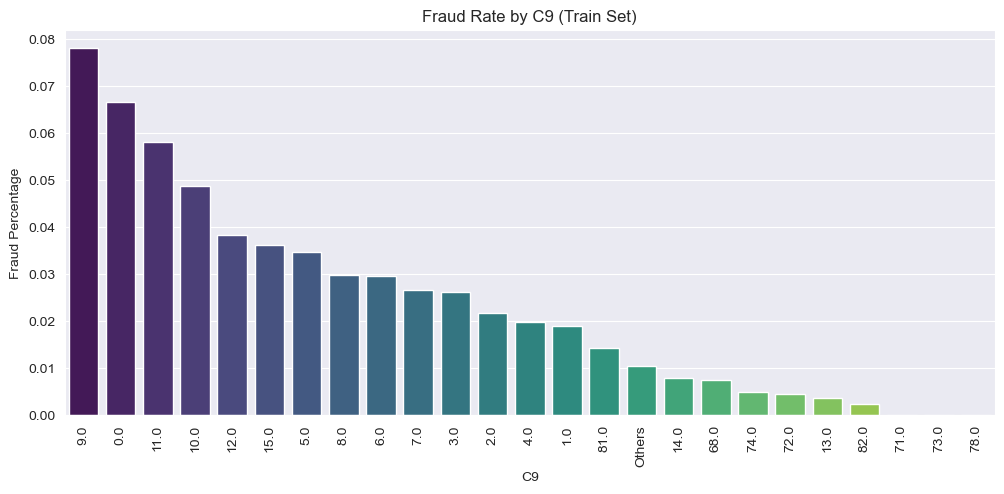

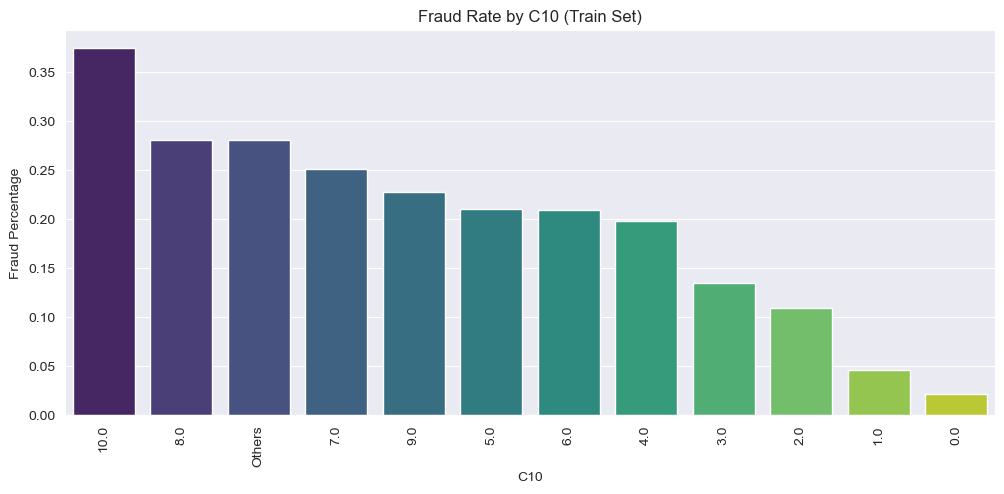

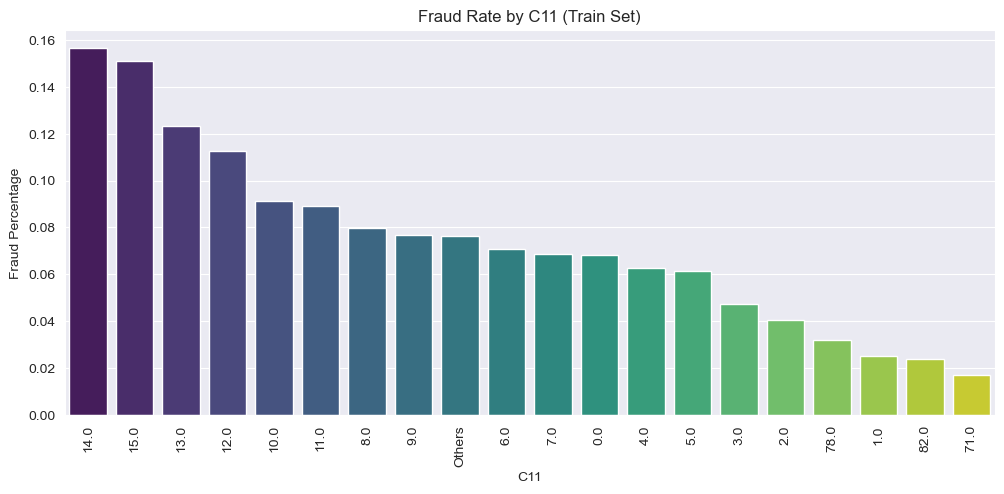

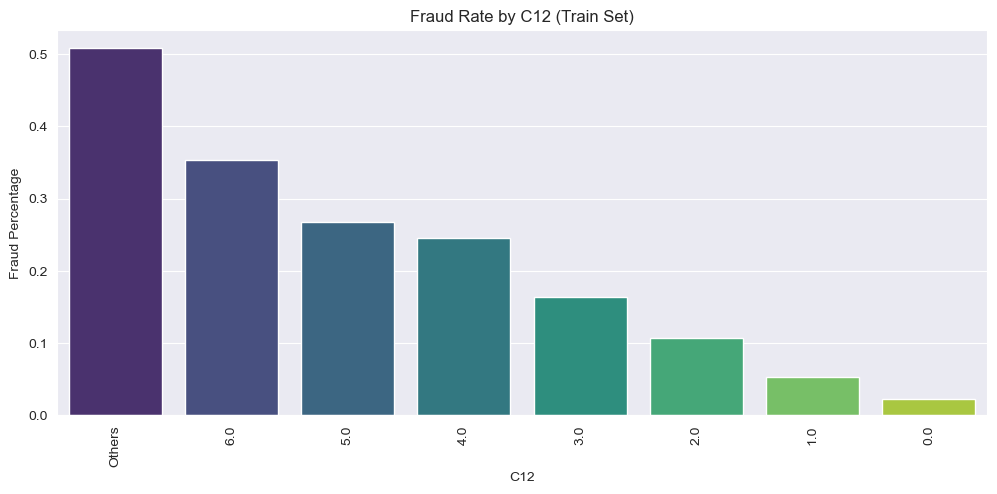

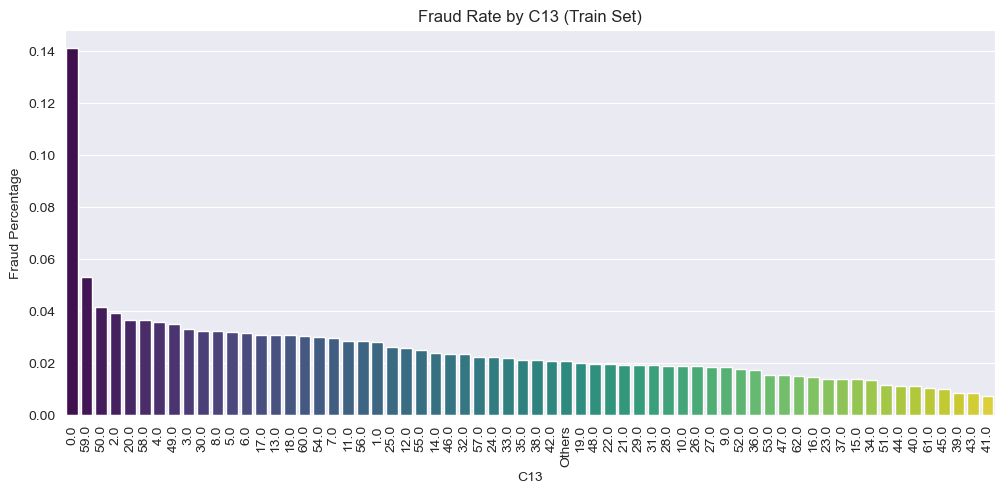

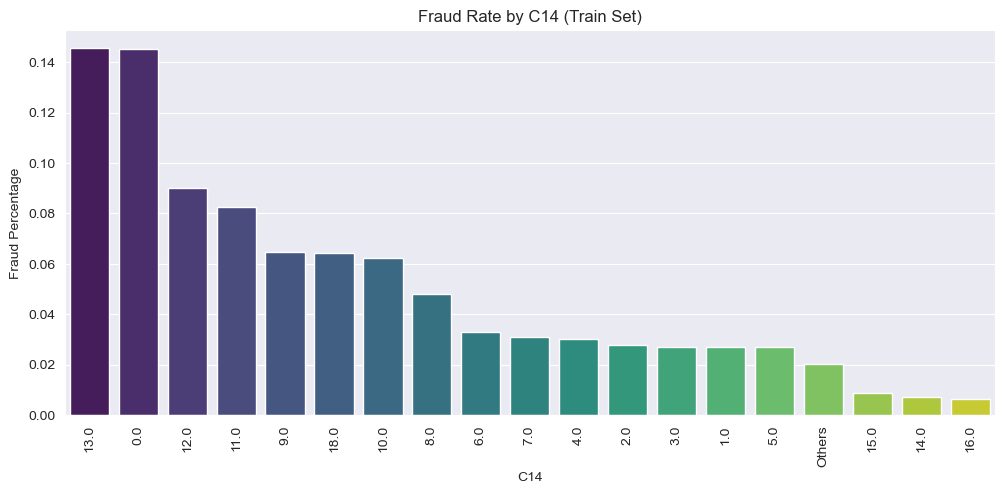

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define function to plot fraud percentage per category
def plot_fraud_percentage(df, col, title_suffix=""):
    fraud_rate = df.groupby(col)["isFraud"].mean().sort_values(ascending=False)

    plt.figure(figsize=(12, 5))
    sns.barplot(x=fraud_rate.index, y=fraud_rate.values, palette="viridis")
    
    plt.xticks(rotation=90)
    plt.ylabel("Fraud Percentage")
    plt.title(f"Fraud Rate by {col} {title_suffix}")
    
    plt.show()

# Define C-columns
c_cols = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
          'C9', 'C10', 'C11', 'C12', 'C13', 'C14']

# Apply rare-value encoding & plot fraud percentages for train set
threshold = 400  # Frequency cutoff

for col in c_cols:
    rare_values = train[col].value_counts()[train[col].value_counts() <= threshold].index
    train.loc[train[col].isin(rare_values), col] = "Others"
    test.loc[test[col].isin(rare_values), col] = "Others"

    # Plot fraud percentage for train set
    plot_fraud_percentage(train, col, "(Train Set)")


### It looks like each column has different columns where fraud rates are highest, let's creat a binary column that indicates whether the row's category matehes the one with the highest fraud probability. This can help a model capture a strong relationshp between certain categories and the target variable. 

In [96]:
# Define function to get highest fraud category and create binary feature
def highest_probability_binary(df_train, df_test, col, target):
    # Calculate fraud probability for each category in the train set
    fraud_rate = df_train.groupby(col)[target].mean()

    # Find the category with the highest fraud rate
    max_category = fraud_rate.idxmax()

    # Create binary columns for train and test set (1 if category matches max_category)
    df_train[col + "_max_fraud"] = (df_train[col] == max_category).astype(int)
    df_test[col + "_max_fraud"] = (df_test[col] == max_category).astype(int)

    return df_train, df_test

# Apply this encoding to each C-column in both train and test sets
c_cols = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']

for col in c_cols:
    # Apply the binary encoding based on the highest fraud probability category
    train, test = highest_probability_binary(train, test, col, 'isFraud')

# Verify the new binary columns for train and test
# train[[col + "_max_fraud" for col in c_cols]].head(), test[[col + "_max_fraud" for col in c_cols]].head()



### TimeDelta Feature
Let's see if the frauds have some specific hour that has highest % of frauds

### Converting to Total Days, Weekdays and Hours
In discussions tab I read an excellent solution to Timedelta column, I will set the link below;

We will use the first date as 2017-12-01 and use the delta time to compute datetime features



In [97]:
import datetime

# Assuming START_DATE is provided and TransactionDT is present in both train and test sets
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")

# Apply transformations to the train set
train["Date"] = train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
train['_Weekdays'] = train['Date'].dt.dayofweek
train['_Hours'] = train['Date'].dt.hour
train['_Days'] = train['Date'].dt.day

# Apply transformations to the test set
test["Date"] = test['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
test['_Weekdays'] = test['Date'].dt.dayofweek
test['_Hours'] = test['Date'].dt.hour
test['_Days'] = test['Date'].dt.day

# Verify the transformations
print(train[['TransactionDT', 'Date', '_Weekdays', '_Hours', '_Days']].head())
print(test[['TransactionDT', 'Date', '_Weekdays', '_Hours', '_Days']].head())



   TransactionDT                Date  _Weekdays  _Hours  _Days
0          86400 2017-12-02 00:00:00          5       0      2
1          86401 2017-12-02 00:00:01          5       0      2
2          86469 2017-12-02 00:01:09          5       0      2
3          86499 2017-12-02 00:01:39          5       0      2
4          86506 2017-12-02 00:01:46          5       0      2
   TransactionDT                Date  _Weekdays  _Hours  _Days
0       18403224 2018-07-02 00:00:24          0       0      2
1       18403263 2018-07-02 00:01:03          0       0      2
2       18403310 2018-07-02 00:01:50          0       0      2
3       18403310 2018-07-02 00:01:50          0       0      2
4       18403317 2018-07-02 00:01:57          0       0      2


In [98]:
print(f"First Date is {train['Date'].dt.date.min()} and the last date is {train['Date'].dt.date.max()} \
      \nTotal Difference in days are {(train['Date'].max() - train['Date'].min()).days} Days")

First Date is 2017-12-02 and the last date is 2018-06-01       
Total Difference in days are 181 Days


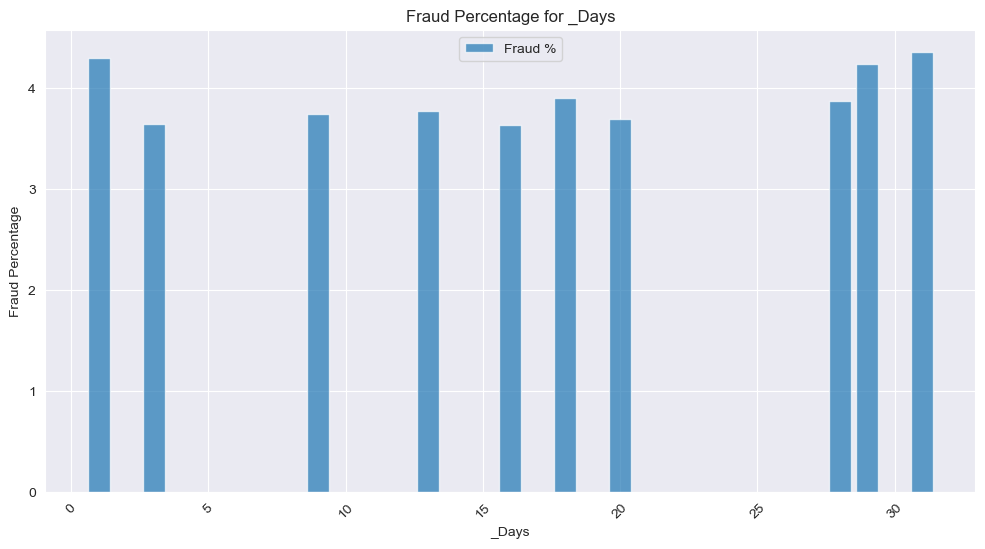

In [99]:
ploting_cnt_amt(train, '_Days')


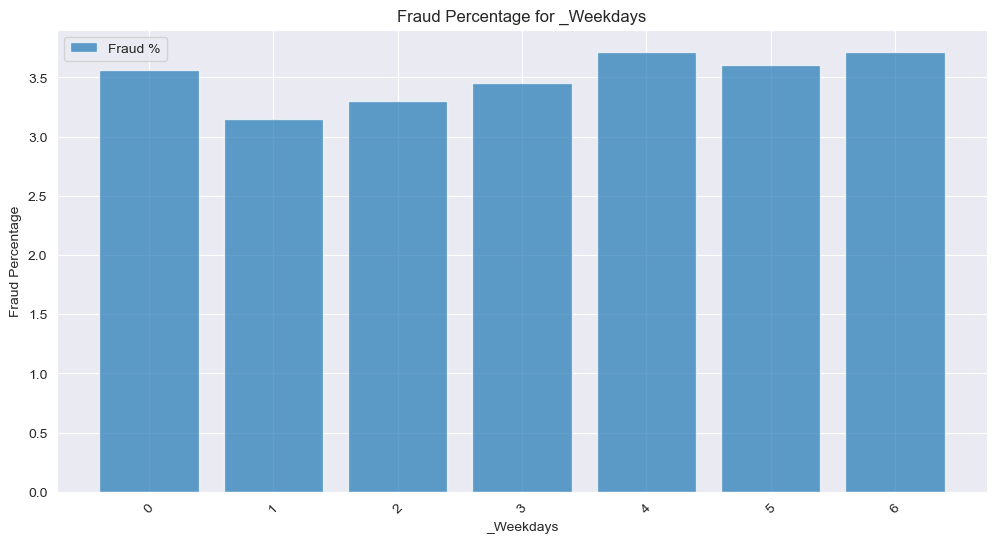

In [100]:
ploting_cnt_amt(train, '_Weekdays')


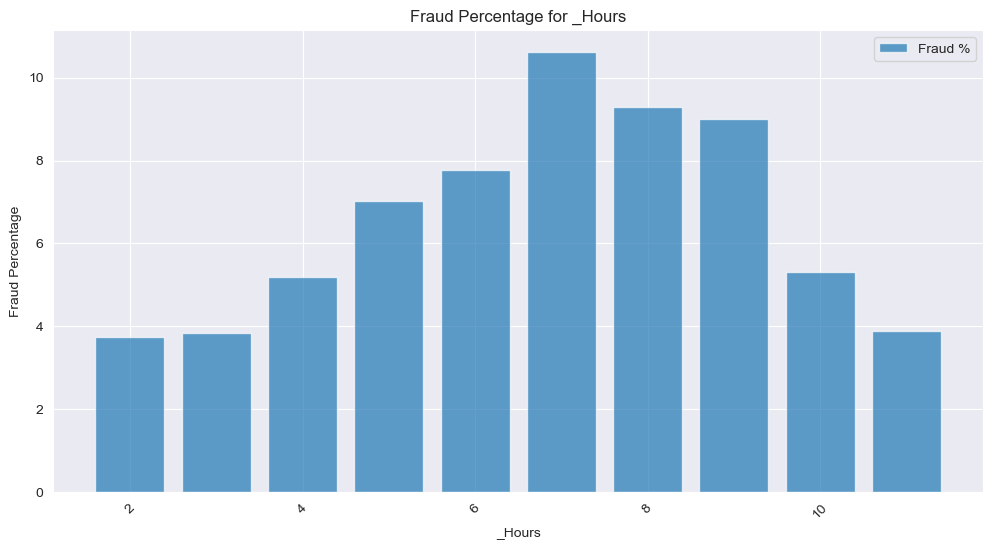

In [101]:
ploting_cnt_amt(train, '_Hours')

In [102]:
import plotly.graph_objects as go
from plotly.offline import iplot
import pandas as pd

# Setting color options
color_op = ['#5527A0', '#BB93D7', '#834CF7', '#6C941E', '#93EAEA', '#7425FF', '#F2098A', '#7E87AC', 
            '#EBE36F', '#7FD394', '#49C35D', '#3058EE', '#44FDCF', '#A38F85', '#C4CEE0', '#B63A05', 
            '#4856BF', '#F0DB1B', '#9FDBD9', '#B123AC']

# Grouping transactions by date in train
train_dates_temp = train.groupby(train.Date.dt.date)['TransactionAmt'].count().reset_index()
train_dates_temp_sum = train.groupby(train.Date.dt.date)['TransactionAmt'].sum().reset_index()

# Grouping transactions by date in test
test_dates_temp = test.groupby(test.Date.dt.date)['TransactionAmt'].count().reset_index()
test_dates_temp_sum = test.groupby(test.Date.dt.date)['TransactionAmt'].sum().reset_index()

# Creating traces for the train dataset
trace_train = go.Scatter(
    x=train_dates_temp['Date'], 
    y=train_dates_temp.TransactionAmt,
    opacity=0.8, 
    line=dict(color=color_op[7]), 
    name='Total Transactions (Train)'
)

trace1_train = go.Scatter(
    x=train_dates_temp_sum.Date, 
    y=train_dates_temp_sum['TransactionAmt'],
    opacity=0.8, 
    line=dict(color=color_op[1]), 
    name="Total Amount (Train)", 
    yaxis='y2'
)

# Creating traces for the test dataset
trace_test = go.Scatter(
    x=test_dates_temp['Date'], 
    y=test_dates_temp.TransactionAmt,
    opacity=0.8, 
    line=dict(color=color_op[10], dash='dash'), 
    name='Total Transactions (Test)'
)

trace1_test = go.Scatter(
    x=test_dates_temp_sum.Date, 
    y=test_dates_temp_sum['TransactionAmt'],
    opacity=0.8, 
    line=dict(color=color_op[5], dash='dash'), 
    name="Total Amount (Test)", 
    yaxis='y2'
)

# Creating the layout
layout = dict(
    title="Total Transactions and Fraud Information by Date (Train vs Test)",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=3, label='3m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible=True),
        type='date'
    ),
    yaxis=dict(title='Total Transactions'),
    yaxis2=dict(
        overlaying='y', anchor='x', side='right',
        zeroline=False, showgrid=False,
        title='Total Transaction Amount'
    )
)

# Creating figure with both train and test traces
fig = dict(data=[trace_train, trace1_train, trace_test, trace1_test], layout=layout)

# Rendering the graph
iplot(fig)  # Equivalent to plt.show()


Features [id_12 to id_38]
categorical features in training identity dataset


In [103]:
train

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,C9_max_fraud,C10_max_fraud,C11_max_fraud,C12_max_fraud,C13_max_fraud,C14_max_fraud,Date,_Weekdays,_Hours,_Days
0,86400,68.500000,W,13926,NaN,150.0,discover,Others,credit,315.0,...,0,0,0,0,0,0,2017-12-02 00:00:00,5,0,2
1,86401,29.000000,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,...,0,0,0,0,0,0,2017-12-02 00:00:01,5,0,2
2,86469,59.000000,W,4663,490.0,150.0,visa,166.0,debit,330.0,...,0,0,0,0,0,0,2017-12-02 00:01:09,5,0,2
3,86499,50.000000,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,...,0,0,0,0,0,0,2017-12-02 00:01:39,5,0,2
4,86506,50.000000,H,4497,514.0,150.0,mastercard,102.0,credit,Others,...,0,0,0,0,0,0,2017-12-02 00:01:46,5,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,15811047,49.000000,W,6550,NaN,150.0,visa,226.0,debit,272.0,...,0,0,0,0,0,0,2018-06-01 23:57:27,4,23,1
590536,15811049,39.500000,W,10444,225.0,150.0,mastercard,224.0,debit,204.0,...,0,0,0,0,0,0,2018-06-01 23:57:29,4,23,1
590537,15811079,30.953125,W,12037,595.0,150.0,mastercard,224.0,debit,231.0,...,0,0,0,0,0,0,2018-06-01 23:57:59,4,23,1
590538,15811088,117.000000,W,7826,481.0,150.0,mastercard,224.0,debit,387.0,...,0,0,0,0,0,0,2018-06-01 23:58:08,4,23,1


In [104]:
id_cols = [col for col in train.columns if "id_" in col]
print(id_cols)
df_id = train[id_cols]
df_id[['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18',
       'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25',
       'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']].describe(include='all')

['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']


,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,...,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
count,144233,127320.0,80044.0,140985,129340,139369.0,4.511300e+04,139318.0,139261.0,5159.0,...,140978,77565,140282,77586.0,73289,77805,140985,140985,140985,140985
unique,2,NaN,NaN,3,2,NaN,NaN,NaN,NaN,NaN,...,2,75,130,NaN,260,4,2,2,2,2
top,NotFound,NaN,NaN,Found,Found,NaN,NaN,NaN,NaN,NaN,...,Found,Windows 10,chrome 63.0,NaN,1920x1080,match_status:2,T,F,T,F
freq,123025,NaN,NaN,67728,66324,NaN,NaN,NaN,NaN,NaN,...,74926,21155,22000,NaN,16874,60011,77814,134066,110452,73922
mean,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN,inf,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,0.0,NaN,NaN,NaN,0.0,1.561523e+00,NaN,NaN,inf,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,10.0,-660.0,NaN,NaN,100.0,1.000000e+01,100.0,100.0,100.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,49.0,-360.0,NaN,NaN,166.0,1.300000e+01,266.0,256.0,252.0,...,NaN,NaN,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,52.0,-300.0,NaN,NaN,166.0,1.500000e+01,341.0,472.0,252.0,...,NaN,NaN,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,52.0,-300.0,NaN,NaN,225.0,1.500000e+01,427.0,533.0,486.5,...,NaN,NaN,NaN,32.0,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
total = len(train)

def cat_feat_ploting(df, col):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.figure(figsize=(14,10))
    plt.suptitle(f'{col} Distributions', fontsize=22)

    plt.subplot(221)
    g = sns.countplot(x=col, data=df, order=tmp[col].values)
    # plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

    g.set_title(f"{col} Distribution", fontsize=19)
    g.set_xlabel(f"{col} Name", fontsize=17)
    g.set_ylabel("Count", fontsize=17)
    # g.set_ylim(0,500000)
    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=14) 

    plt.subplot(222)
    g1 = sns.countplot(x=col, hue='isFraud', data=df, order=tmp[col].values)
    plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
    gt = g1.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, color='black', order=tmp[col].values, legend=False)
    gt.set_ylabel("% of Fraud Transactions", fontsize=16)

    g1.set_title(f"{col} by Target(isFraud)", fontsize=19)
    g1.set_xlabel(f"{col} Name", fontsize=17)
    g1.set_ylabel("Count", fontsize=17)

    plt.subplot(212)
    g3 = sns.boxenplot(x=col, y='TransactionAmt', hue='isFraud', 
                       data=df[df['TransactionAmt'] <= 2000], order=tmp[col].values )
    g3.set_title("Transaction Amount Distribuition by ProductCD and Target", fontsize=20)
    g3.set_xlabel("ProductCD Name", fontsize=17)
    g3.set_ylabel("Transaction Values", fontsize=17)

    plt.subplots_adjust(hspace = 0.4, top = 0.85)

    plt.show()

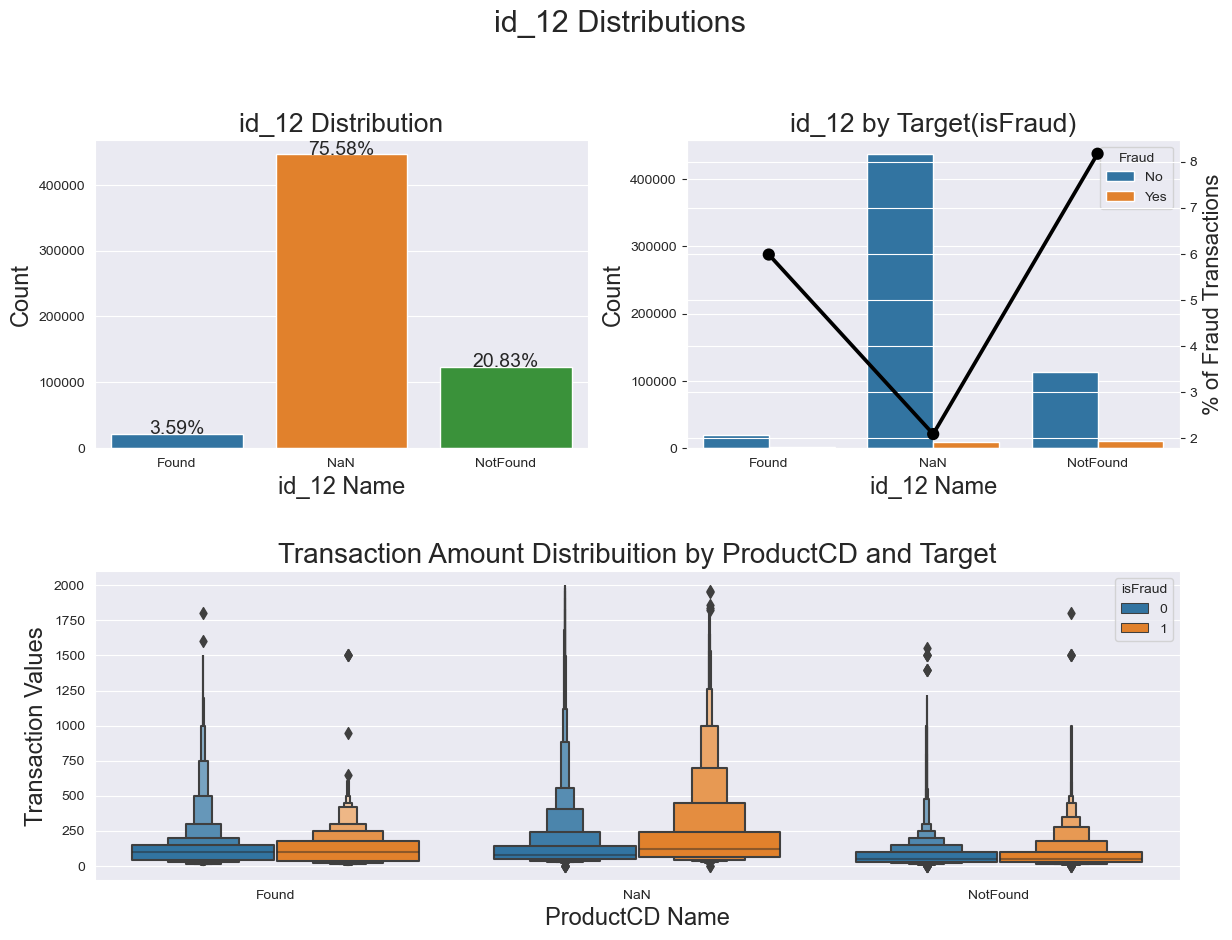

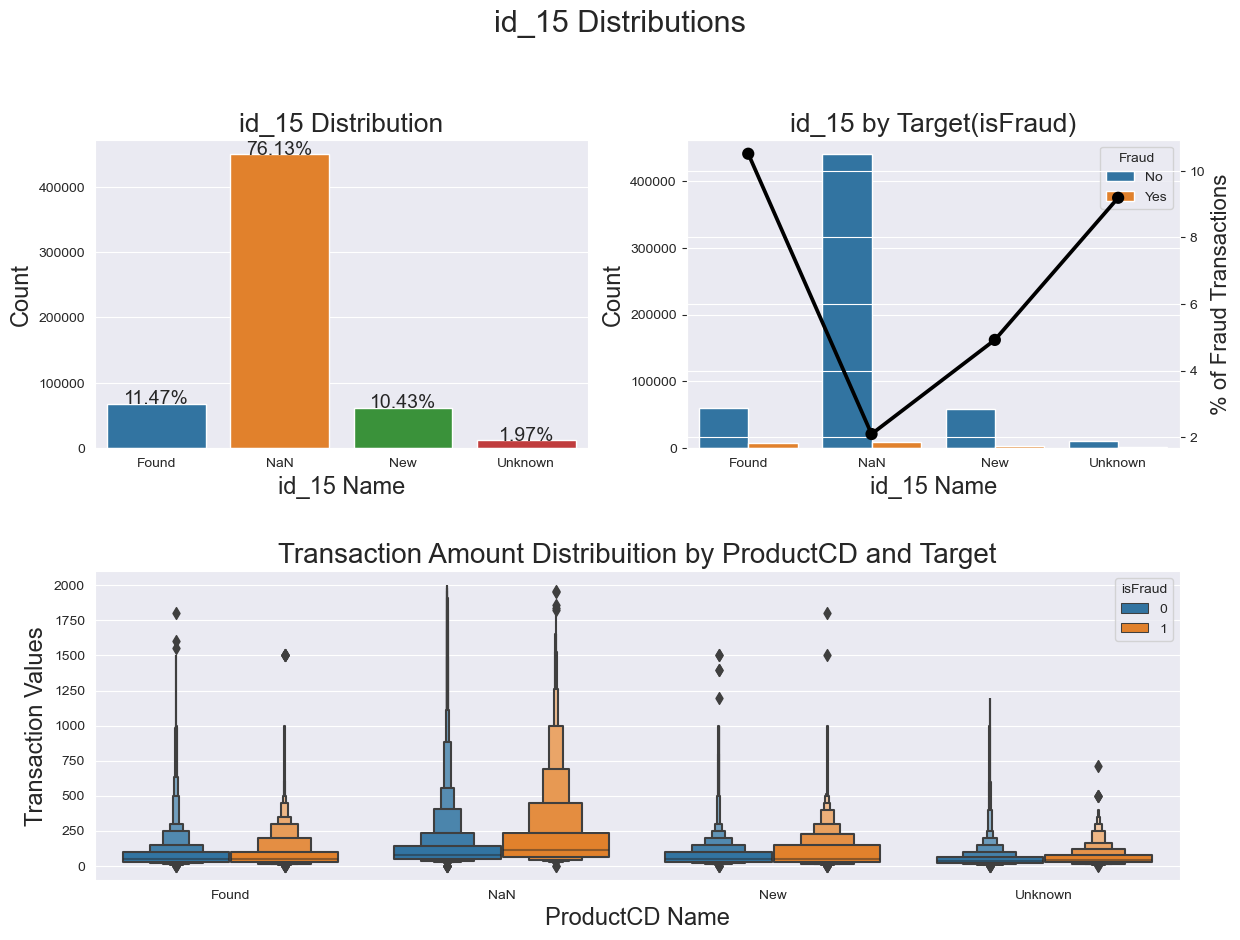

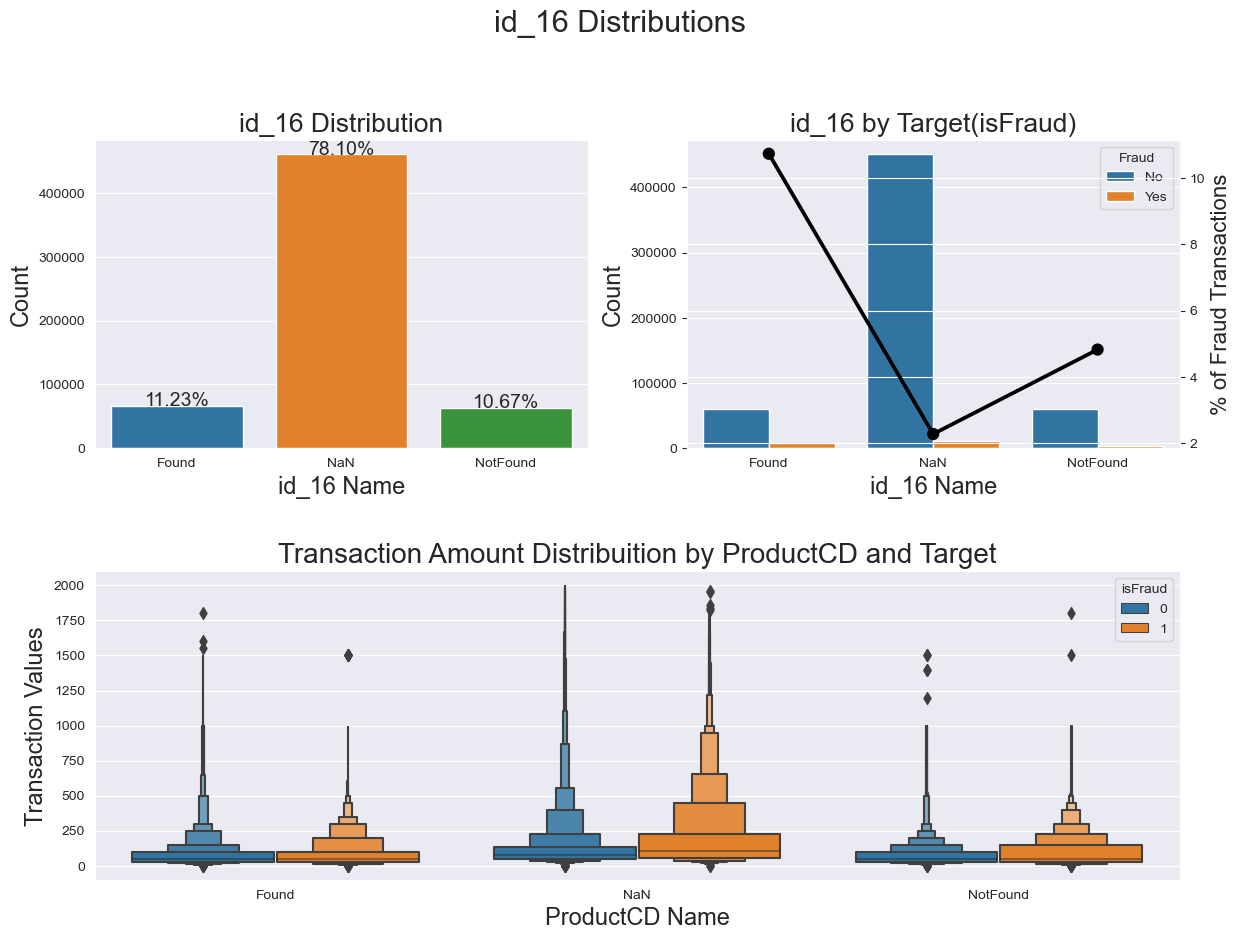

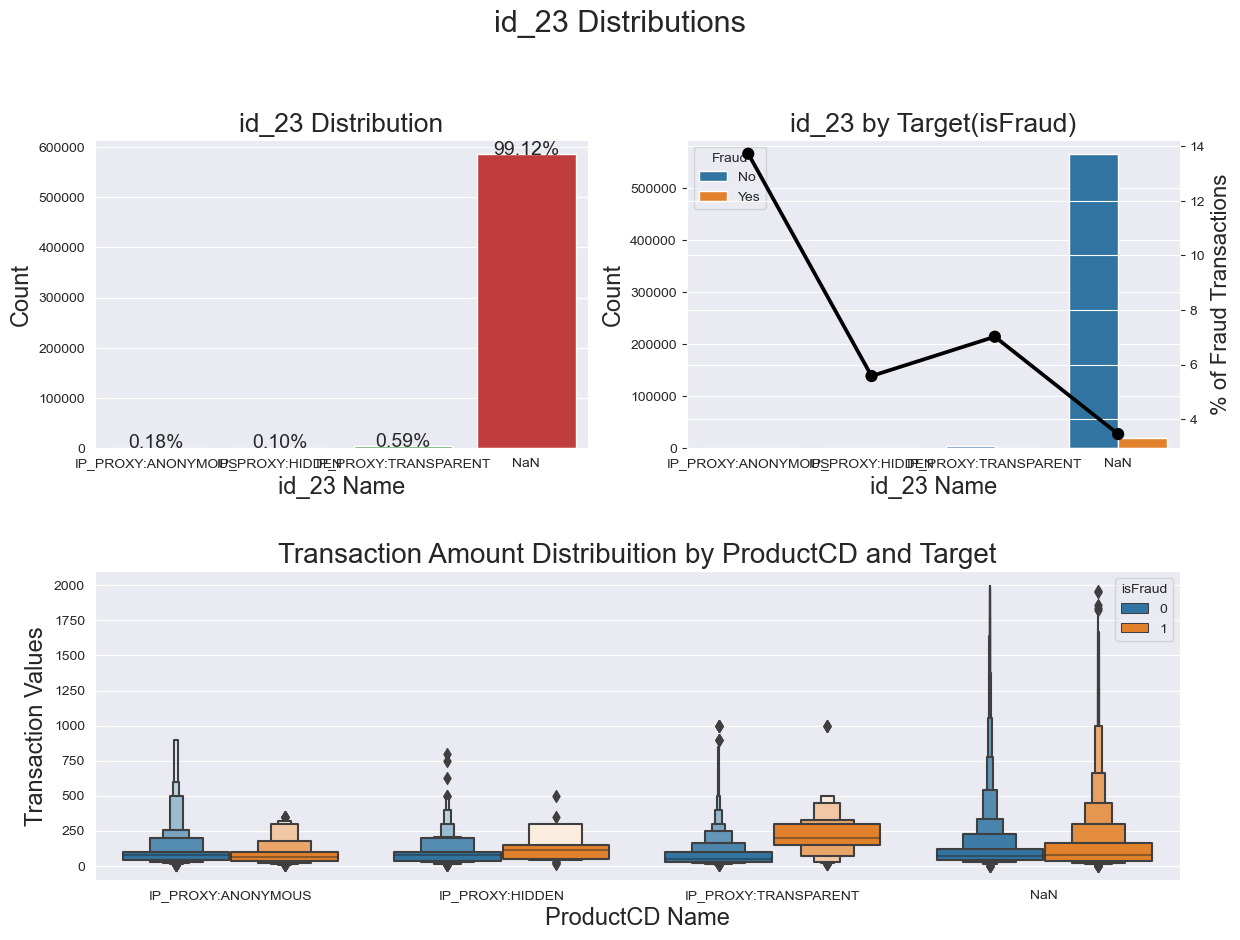

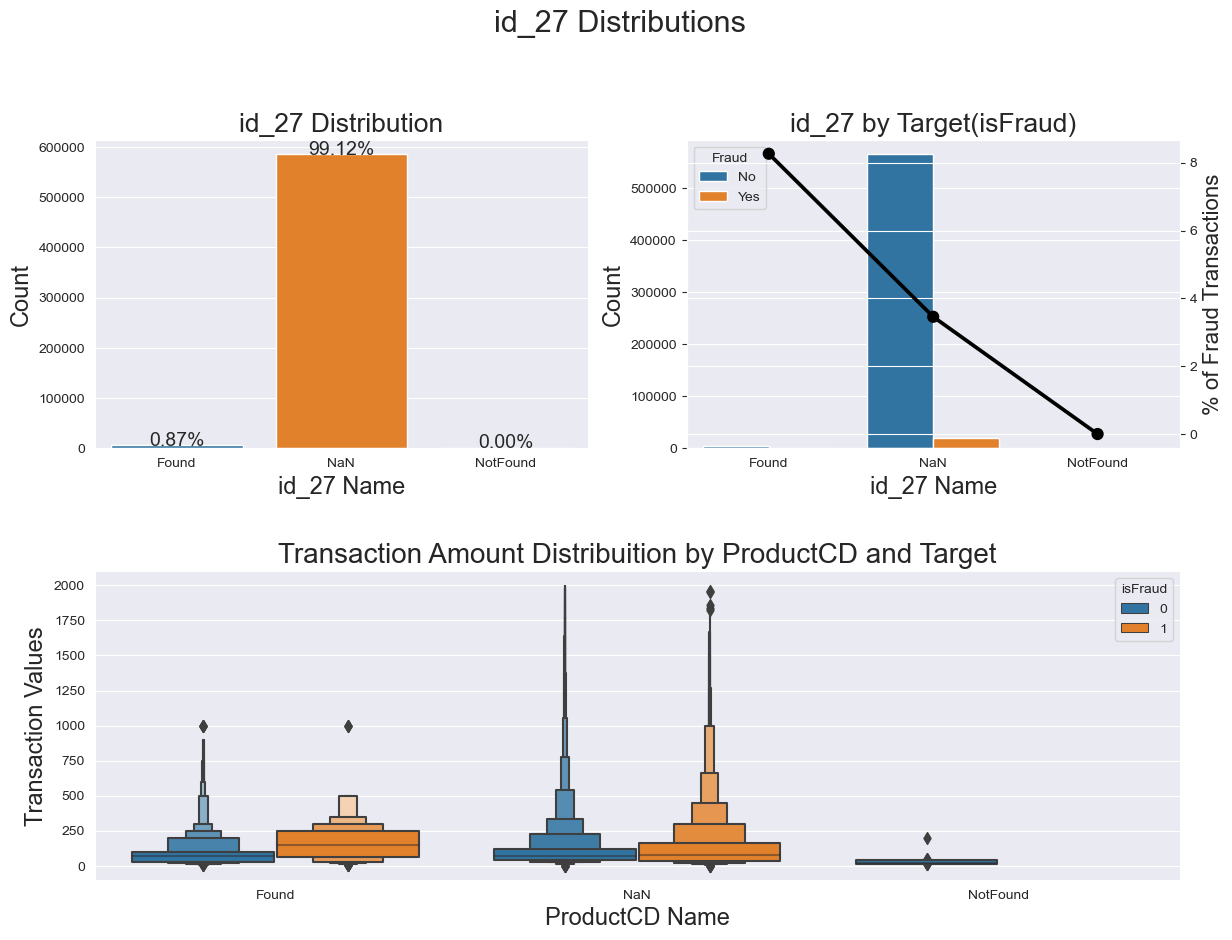

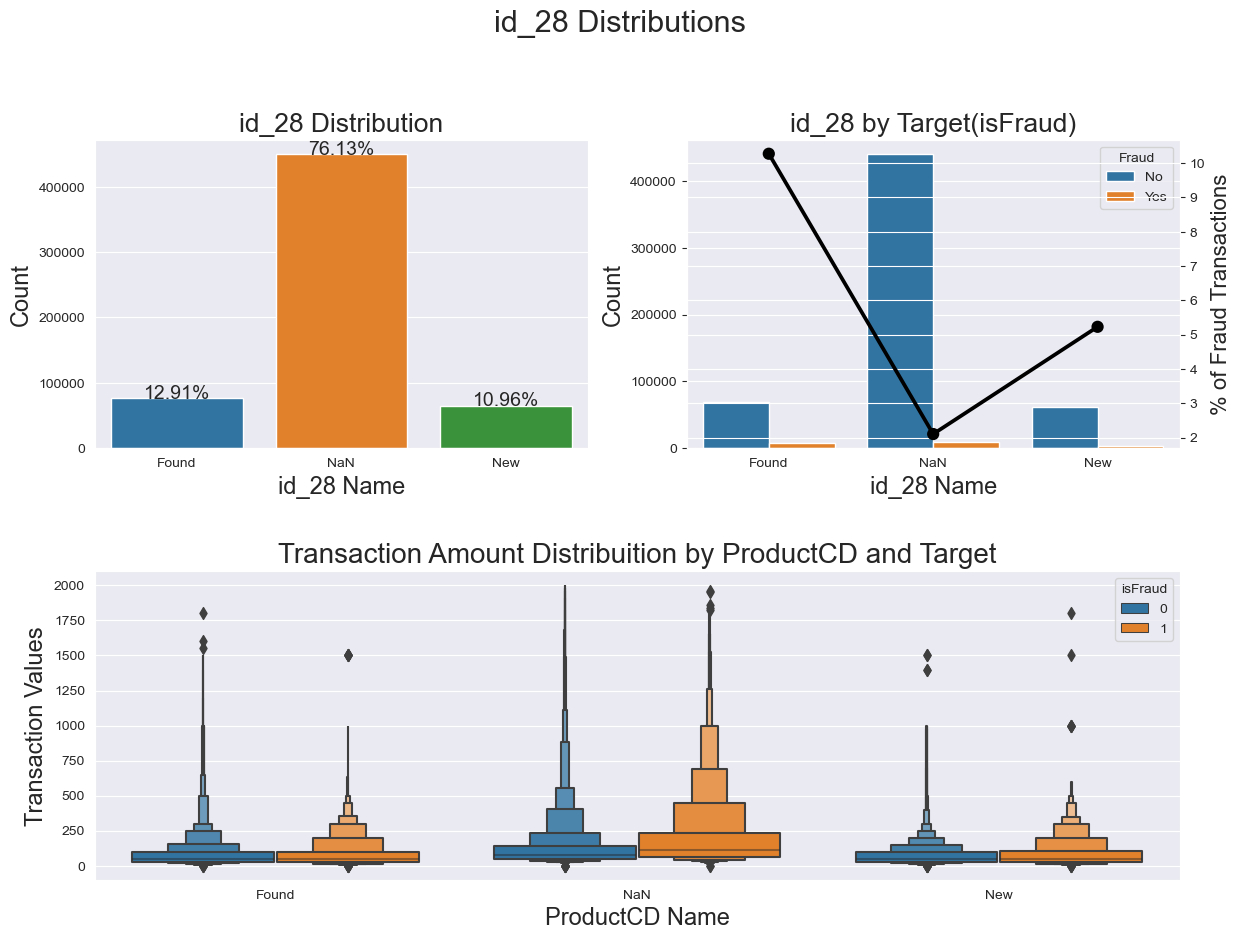

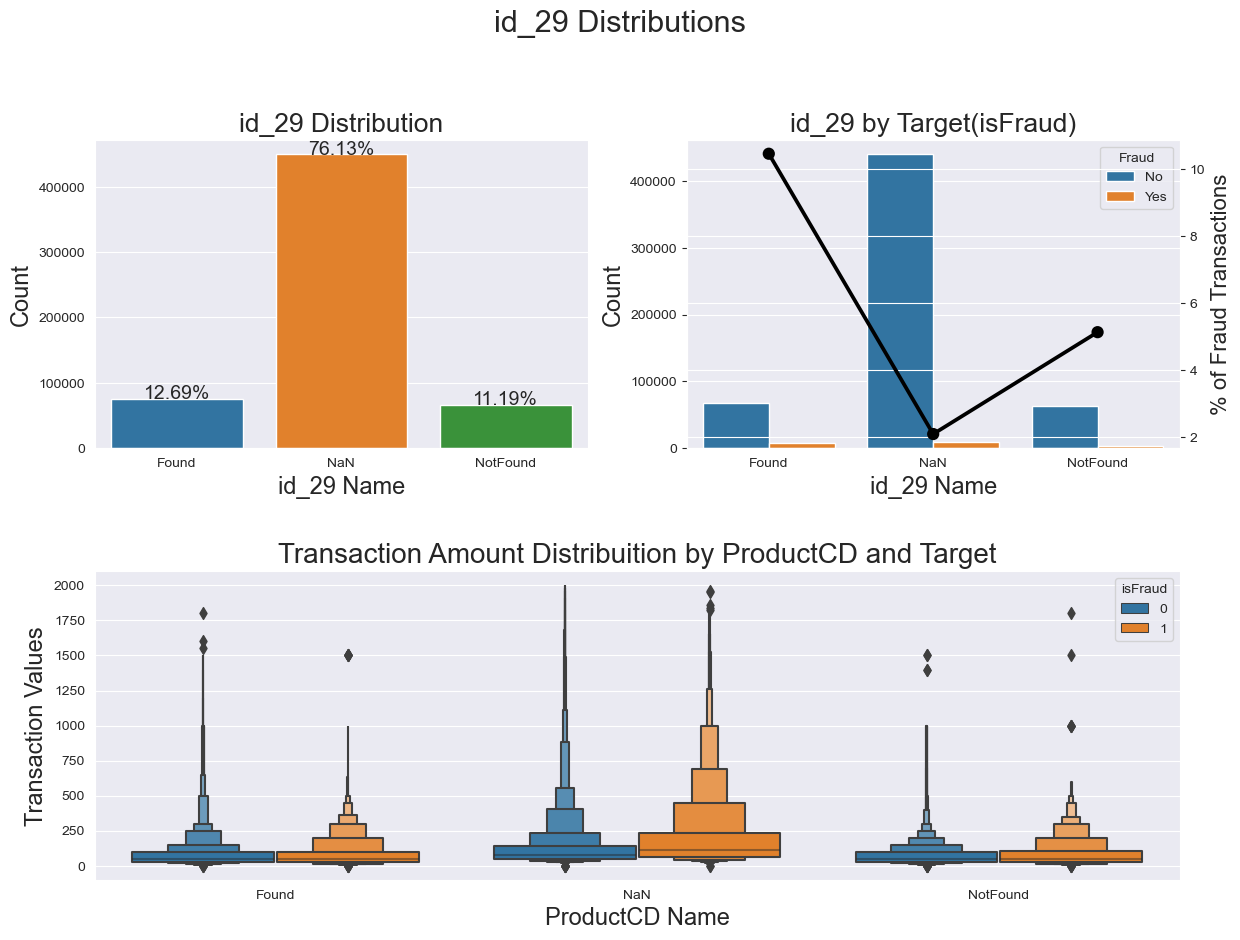

In [106]:
for col in ['id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', ]:
    train[col] = train[col].fillna('NaN')
    test[col] = test[col].fillna('NaN')
    cat_feat_ploting(train, col)


In [107]:
train['id_30'].value_counts()

Windows 10          21155
Windows 7           13110
iOS 11.2.1           3722
iOS 11.1.2           3699
Android 7.0          2871
                    ...  
func                   10
iOS 11.4.0              5
Mac OS X 10_13_5        4
Windows                 3
iOS 11.4.1              1
Name: id_30, Length: 75, dtype: int64

In [108]:
### id_30 seems to be some sort of tool to identify the OS of the device, let's see if we can extract some information from it
### first we'll separate it out into the broader OS it uses instead of the specific version

In [109]:
train.loc[train['id_30'].str.contains('Windows', na=False), 'id_30'] = 'Windows'
train.loc[train['id_30'].str.contains('iOS', na=False), 'id_30'] = 'iOS'
train.loc[train['id_30'].str.contains('Mac OS', na=False), 'id_30'] = 'Mac'
train.loc[train['id_30'].str.contains('Android', na=False), 'id_30'] = 'Android'
train['id_30'].fillna("NAN", inplace=True)


In [110]:
test.loc[test['id_30'].str.contains('Windows', na=False), 'id_30'] = 'Windows'
test.loc[test['id_30'].str.contains('iOS', na=False), 'id_30'] = 'iOS'
test.loc[test['id_30'].str.contains('Mac OS', na=False), 'id_30'] = 'Mac'
test.loc[test['id_30'].str.contains('Android', na=False), 'id_30'] = 'Android'
test['id_30'].fillna("NAN", inplace=True)

In [111]:
train['id_30'].value_counts()

NAN        512975
Windows     36739
iOS         19782
Mac         13580
Android      6303
Linux        1136
other          15
func           10
Name: id_30, dtype: int64

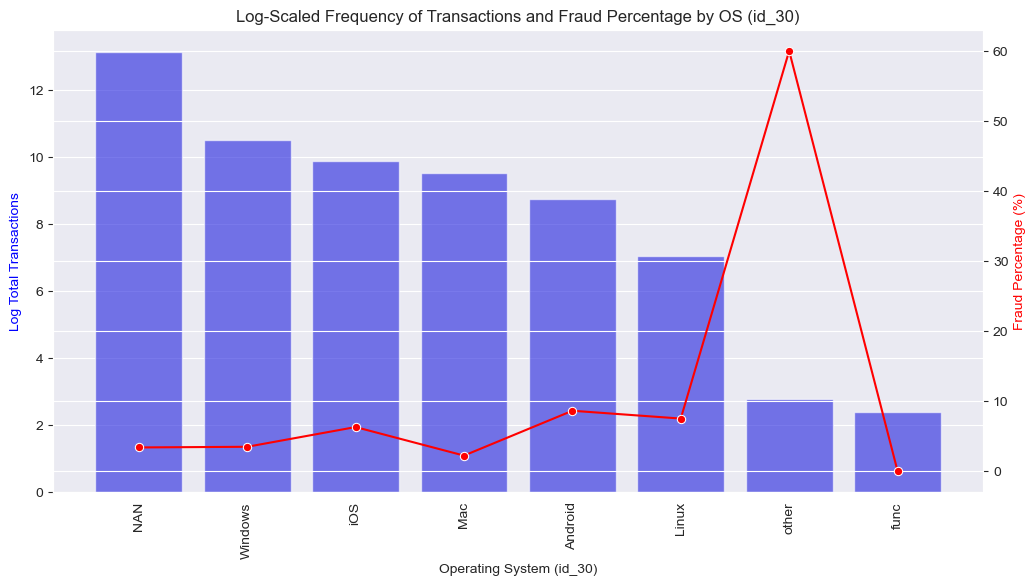

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Count total transactions per OS
os_counts = train['id_30'].value_counts()

# Compute fraud percentage per OS
fraud_rates = train.groupby('id_30')['isFraud'].mean() * 100  # Convert to percentage

# Combine into a DataFrame for plotting
os_df = pd.DataFrame({'Total Transactions': os_counts, 'Fraud Percentage': fraud_rates}).reset_index()
os_df.columns = ['OS', 'Total Transactions', 'Fraud Percentage']

# Sort by total transactions for better visualization
os_df = os_df.sort_values(by='Total Transactions', ascending=False)

# Apply log scale to transaction counts (avoid log(0) by adding 1)
os_df["Log Total Transactions"] = np.log1p(os_df["Total Transactions"])

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot bar chart for total transactions (log scale)
sns.barplot(data=os_df, x="OS", y="Log Total Transactions", ax=ax1, color="blue", alpha=0.6)

# Create second y-axis for fraud percentage
ax2 = ax1.twinx()
sns.lineplot(data=os_df, x="OS", y="Fraud Percentage", ax=ax2, color="red", marker="o")

# Rotate x-axis labels for readability
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

# Labels and titles
ax1.set_ylabel("Log Total Transactions", color="blue")
ax2.set_ylabel("Fraud Percentage (%)", color="red")
ax1.set_xlabel("Operating System (id_30)")
plt.title("Log-Scaled Frequency of Transactions and Fraud Percentage by OS (id_30)")

# Show plot
plt.show()


In [113]:
train.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,C9_max_fraud,C10_max_fraud,C11_max_fraud,C12_max_fraud,C13_max_fraud,C14_max_fraud,Date,_Weekdays,_Hours,_Days
0,86400,68.5,W,13926,NaN,150.0,discover,Others,credit,315.0,...,0,0,0,0,0,0,2017-12-02 00:00:00,5,0,2
1,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,...,0,0,0,0,0,0,2017-12-02 00:00:01,5,0,2
2,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,...,0,0,0,0,0,0,2017-12-02 00:01:09,5,0,2
3,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,...,0,0,0,0,0,0,2017-12-02 00:01:39,5,0,2
4,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,Others,...,0,0,0,0,0,0,2017-12-02 00:01:46,5,0,2


In [114]:
### It appears that any customer that isn't using one of the more common OS's is more likely to be fraudulent, let's create a binary feature that indicates whether the OS is 'other'
# Create binary feature for whether 'id_30' is categorized as 'Other'
train['id_30_is_other'] = (train['id_30'] == 'Other').astype(int)
test['id_30_is_other'] = (test['id_30'] == 'Other').astype(int)

# Check fraud rate for 'Other' vs non-'Other' OS
fraud_rate_check = train.groupby('id_30_is_other')['isFraud'].mean() * 100
print(fraud_rate_check)


id_30_is_other
0    3.499001
Name: isFraud, dtype: float64


### id_31 looks like it's browser information, let's see if we can extract some information from it
### first let's clean up the data a bit

In [115]:
train.loc[train['id_31'].str.contains('chrome', na=False), 'id_31'] = 'Chrome'
train.loc[train['id_31'].str.contains('firefox', na=False), 'id_31'] = 'Firefox'
train.loc[train['id_31'].str.contains('safari', na=False), 'id_31'] = 'Safari'
train.loc[train['id_31'].str.contains('edge', na=False), 'id_31'] = 'Edge'
train.loc[train['id_31'].str.contains('ie', na=False), 'id_31'] = 'IE'
train.loc[train['id_31'].str.contains('samsung', na=False), 'id_31'] = 'Samsung'
train.loc[train['id_31'].str.contains('opera', na=False), 'id_31'] = 'Opera'
train['id_31'].fillna("NAN", inplace=True)
train.loc[train.id_31.isin(train.id_31.value_counts()[train.id_31.value_counts() < 200].index), 'id_31'] = "Others"

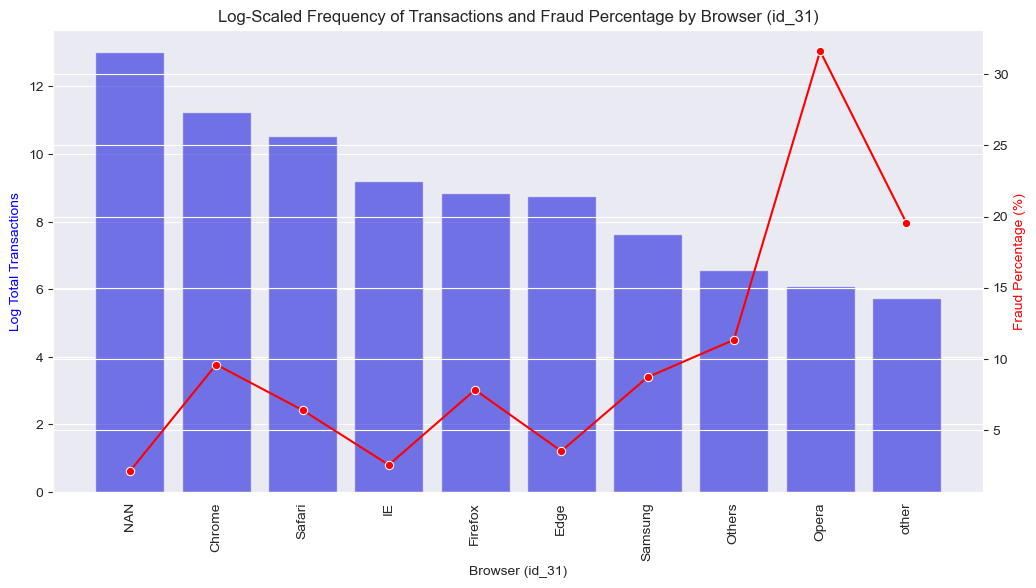

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Count total transactions per browser
browser_counts = train['id_31'].value_counts()

# Compute fraud percentage per browser
fraud_rates = train.groupby('id_31')['isFraud'].mean() * 100  # Convert to percentage

# Combine into a DataFrame for plotting
browser_df = pd.DataFrame({'Total Transactions': browser_counts, 'Fraud Percentage': fraud_rates}).reset_index()
browser_df.columns = ['Browser', 'Total Transactions', 'Fraud Percentage']

# Sort by total transactions for better visualization
browser_df = browser_df.sort_values(by='Total Transactions', ascending=False)

# Apply log scale to transaction counts (avoid log(0) by adding 1)
browser_df["Log Total Transactions"] = np.log1p(browser_df["Total Transactions"])

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot bar chart for total transactions (log scale)
sns.barplot(data=browser_df, x="Browser", y="Log Total Transactions", ax=ax1, color="blue", alpha=0.6)

# Create second y-axis for fraud percentage
ax2 = ax1.twinx()
sns.lineplot(data=browser_df, x="Browser", y="Fraud Percentage", ax=ax2, color="red", marker="o")

# Rotate x-axis labels for readability
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

# Labels and titles
ax1.set_ylabel("Log Total Transactions", color="blue")
ax2.set_ylabel("Fraud Percentage (%)", color="red")
ax1.set_xlabel("Browser (id_31)")
plt.title("Log-Scaled Frequency of Transactions and Fraud Percentage by Browser (id_31)")

# Show plot
plt.show()

##### Looks like there are a lot of fraudulent transactions going on using 'Opera' and other browsers, let's create a categorical feature that indicates whether the browser is 'Opera' or 'Other'

In [117]:
train['id_31_is_opera'] = (train['id_31'] == 'Opera').astype(int)
test['id_31_is_opera'] = (test['id_31'] == 'Opera').astype(int)

train['id_31_is_other'] = (train['id_31'] == 'Other').astype(int)
test['id_31_is_other'] = (test['id_31'] == 'Other').astype(int)


In [118]:
### Let's try modeling with what we've created!
##### First we'll drop any cols with just one value in them, any colums with the vast majorty of the values as null, and 

In [119]:
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]
one_value_cols == one_value_cols_test

many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.9]

cols_to_drop  = list(set(many_null_cols + many_null_cols_test +
                        one_value_cols+ one_value_cols_test))
# cols_to_drop.remove('isFraud')

train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)


### Let's encode our categorical variables!

In [120]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 
            'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 
            'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4', 'P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9'
            'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']

for col in cat_cols:
    print(col)
    if col in train.columns:
        le = LabelEncoder()

        # Convert NaN values to a string "NaN" before encoding
        train[col] = train[col].astype(str).fillna("NaN")
        test[col] = test[col].astype(str).fillna("NaN")

        # Fit label encoder only on combined train + test unique values
        le.fit(np.concatenate([train[col].values, test[col].values], axis=0))

        # Transform train and test sets
        train[col] = le.transform(train[col])
        test[col] = test[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)  # Handle unseen categories

id_12
id_13
id_14
id_15
id_16
id_17
id_18
id_19
id_20
id_21
id_22
id_23
id_24
id_25
id_26
id_27
id_28
id_29
id_30
id_31
id_32
id_33
id_34
id_35
id_36
id_37
id_38
DeviceType
DeviceInfo
ProductCD
card4
card6
M4
P_emaildomain
R_emaildomain
card1
card2
card3
card5
addr1
addr2
M1
M2
M3
M5
M6
M7
M8
M9C1
C2
C3
C4
C5
C6
C7
C8
C9
C10
C11
C12
C13
C14


#### Let's drop any columns that are highly correlated with each other

In [121]:
threshold = 0.98
    
# Absolute value correlation matrix
corr_matrix = train[train['isFraud'].notnull()].corr().abs()

# Getting the upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))
df_train = train.drop(columns = to_drop)
test = test.drop(columns = to_drop)

There are 64 columns to remove.


In [122]:
X_train = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT'], axis=1)
y_train = train.sort_values('TransactionDT')['isFraud']
X_test = test.sort_values('TransactionDT').drop(['TransactionDT'], axis=1)
del train
test = test[["TransactionDT"]]

In [154]:
X_train = reduce_mem_usage(X_train)
X_test = reduce_mem_usage(X_test)
X = X_train
y= y_train
gc.collect()

Mem. usage decreased to 532.00 Mb (0.0% reduction)
Mem. usage decreased to 368.70 Mb (0.0% reduction)


0

### Hyperparameter Optimization Using Hyperopt

##### The objective function trains an XGBoost classifier using a set of hyperparameters suggested by Hyperopt.
##### It performs cross-validation to measure model performance.
##### The function returns the negative ROC AUC score because Hyperopt minimizes the objective function.
##### Time Series Cross-Validation (TimeSeriesSplit)

### Ensures that future data is never used to predict past data.
##### Splits the dataset into EPOCHS=5 folds for validation.

### Hyperparameter Search Space (space)
##### Defines the range of values that Hyperopt will explore for each hyperparameter.
##### max_depth , min_child_weight and gamma to mitigate overfitting
##### learning_rate to control the step size in gradient descent
##### colsample_bytree and subsample to prevent overfitting by randomly sampling features and rows
##### reg_alpha and reg_lambda for L1 and L2 regularization

In [124]:
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb

def objective(params):
    """
    Objective function for Hyperopt to optimize XGBoost hyperparameters.
    
    Parameters:
    params (dict): Dictionary of hyperparameters suggested by Hyperopt.

    Returns:
    float: Negative mean ROC AUC score from cross-validation.
    """

    print("\n############## New Run ################")
    print("PARAMETERS: ")
    print(f"params  = {params}")
    
    # Formatting and type conversion for hyperparameters
    params = {
        'max_depth': int(params['max_depth']),  # Convert depth to integer
        'gamma': "{:.3f}".format(params['gamma']),  # Format gamma as a 3-decimal string
        'reg_alpha': "{:.3f}".format(params['reg_alpha']),  # Format alpha
        'learning_rate': "{:.3f}".format(params['learning_rate']),  # Format learning rate
        'num_leaves': '{:.3f}'.format(params['num_leaves']),  # Format num_leaves
        'min_child_samples': '{:.3f}'.format(params['min_child_samples']),  # Format min_child_samples
        'feature_fraction': '{:.3f}'.format(params['feature_fraction']),  # Format feature_fraction
        'bagging_fraction': '{:.3f}'.format(params['bagging_fraction'])  # Format bagging_fraction
    }
    
    # Define number of cross-validation splits
    EPOCHS = 5
    tss = TimeSeriesSplit(n_splits=EPOCHS)
    
    score_mean = 0  # Initialize score accumulator
    print("CV SCORE: ")

    # Perform Time Series Split cross-validation
    for tr_idx, val_idx in tss.split(X_train, y_train):
        # Initialize XGBoost Classifier with given parameters
        clf = xgb.XGBClassifier(
            n_estimators=600,  # Number of boosting rounds
            random_state=4,  # Set random seed for reproducibility
            tree_method='gpu_hist',  # Use GPU-accelerated histogram-based training
            **params  # Unpack hyperparameters
        )

        # Split training data into train and validation sets
        X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
        y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        
        # Train the model
        clf.fit(X_tr, y_tr)
        
        # Predict probabilities for the validation set
        y_pred_train = clf.predict_proba(X_vl)[:, 1]  # Get probability for class 1
        
        # Calculate ROC AUC score
        score = roc_auc_score(y_vl, y_pred_train)
        score_mean += score  # Accumulate scores
        
        print(f'ROC AUC {score}')  # Print individual fold score
    
    # Free memory after training
    del X_tr, X_vl, y_tr, y_vl, clf, y_pred_train    
    gc.collect()  # Run garbage collection
    
    # Print and return mean ROC AUC score
    print(f'Mean ROC_AUC: {score_mean / EPOCHS}')
    return -score_mean / EPOCHS  # Hyperopt minimizes the objective, so return negative score


# Define search space for Hyperopt
space = {
    'max_depth': hp.quniform('max_depth', 2, 20, 2),  # Integer values between 2 and 20
    'reg_alpha':  hp.uniform('reg_alpha', 0.01, 0.9),  # Regularization alpha between 0.01 and 0.9
    'reg_lambda': hp.uniform('reg_lambda', 0.1, 1.0),  # Regularization lambda between 0.1 and 1.0
    'learning_rate': hp.uniform('learning_rate', 0.05, 0.2),  # Learning rate between 0.05 and 0.2
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),  # Fraction of columns to sample per tree
    'gamma': hp.uniform('gamma', 0.0, 0.8),  # Minimum loss reduction required to make a further partition
    'num_leaves': hp.choice('num_leaves', list(range(20, 500, 25))),  # Number of leaves in tree-based models
    'min_child_samples': hp.choice('min_child_samples', list(range(10, 80, 3))),  # Minimum samples required in a child
    'feature_fraction': hp.choice('feature_fraction', [0.6, 0.7, 0.8, 0.9, 1]),  # Fraction of features used in boosting
    'bagging_fraction': hp.choice('bagging_fraction', [0.6, 0.7, 0.8, 0.9, 1])  # Fraction of data used for boosting
}


In [131]:
X_train.drop('M9', axis=1, inplace = True)
X_test.drop('M9', axis=1, inplace = True)

In [134]:
X_train.drop('C1', axis=1, inplace = True)
X_test.drop('C1', axis=1, inplace = True)

In [138]:
X_train.drop('Date', axis=1, inplace = True)
X_test.drop('Date', axis=1, inplace = True)

In [157]:
from sklearn.model_selection import train_test_split

In [159]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)


#### Initialize Trials object to store results

In [160]:
# Set algoritm parameters
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Print best parameters
# best_params = space_eval(space, best)

                                                      
############## New Run ################
PARAMETERS:                                           
params  = {'bagging_fraction': 1, 'colsample_bytree': 0.5020785801915761, 'feature_fraction': 0.7, 'gamma': 0.2955548064387461, 'learning_rate': 0.17320850959586492, 'max_depth': 12.0, 'min_child_samples': 61, 'num_leaves': 95, 'reg_alpha': 0.22509750292979763, 'reg_lambda': 0.3816170626823293}
CV SCORE:                                             
[21:07:12] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bagging_fraction", "feature_fraction", "min_child_samples", "num_leaves" } are not used.

ROC AUC 0.9143897807643191                            
[21:07:26] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bagging_frac

In [161]:
print("BEST PARAMS: ", best)

best['max_depth'] = int(best['max_depth'])
# best['learning_rate'] = 0.01

BEST PARAMS:  {'bagging_fraction': 3, 'colsample_bytree': 0.7537929153408816, 'feature_fraction': 2, 'gamma': 0.06465028893376523, 'learning_rate': 0.06992483956481604, 'max_depth': 18.0, 'min_child_samples': 8, 'num_leaves': 2, 'reg_alpha': 0.8442865410178233, 'reg_lambda': 0.9859370327909126}


In [162]:
sample_submission = pd.read_csv(r'C:\Users\abajp\PycharmProjects\Fraud Detection\ieee-fraud-detection\sample_submission.csv', index_col='TransactionID')


In [163]:
%%time
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
EPOCHS = 3
tss = TimeSeriesSplit(n_splits=EPOCHS)
y_preds = np.zeros(sample_submission.shape[0])
y_oof = np.zeros(X_train.shape[0])
for tr_idx, val_idx in tss.split(X_train, y_train):
    clf = xgb.XGBClassifier(
        n_estimators=2000,
        **best,
        tree_method='gpu_hist'
    )
    
    X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    clf.fit(X_tr, y_tr)
    y_pred_train = clf.predict_proba(X_vl)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    y_preds+= clf.predict_proba(X_test)[:,1] / EPOCHS
    
del X_tr, X_vl, y_tr, y_vl, clf, y_pred_train, y_oof   
gc.collect()


[21:56:27] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bagging_fraction", "feature_fraction", "min_child_samples", "num_leaves" } are not used.

ROC AUC 0.9316106181243722
[21:57:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bagging_fraction", "feature_fraction", "min_child_samples", "num_leaves" } are not used.

ROC AUC 0.9474255435649386
[21:58:44] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bagging_fraction", "feature_fraction", "min_child_samples", "num_leaves" } are not used.

ROC AUC 0.9567786961245739
Wall time: 4min 13s


193

In [164]:
clf = xgb.XGBClassifier(
    n_estimators=5000,
    **best,
    tree_method='gpu_hist'
)

clf.fit(X_train, y_train)

y_preds_nocv = clf.predict_proba(X_test)[:,1] 

[22:00:48] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bagging_fraction", "feature_fraction", "min_child_samples", "num_leaves" } are not used.



In [166]:
roc_auc_score(y_test, y_preds_nocv)

0.9679023789404844

In [168]:
clf = xgb.XGBClassifier(
    n_estimators=5000,
    **best,
    tree_method='gpu_hist'
)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X, y, cv=5)


[03:46:10] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bagging_fraction", "feature_fraction", "min_child_samples", "num_leaves" } are not used.

[03:50:27] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bagging_fraction", "feature_fraction", "min_child_samples", "num_leaves" } are not used.

[03:54:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bagging_fraction", "feature_fraction", "min_child_samples", "num_leaves" } are not used.

[03:59:02] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bagging_fraction", "feature_fraction", "min_ch

In [171]:
scores
# We got high Scores on the validation set, but we need to check the scores on the test set
# Possibility of overfitting

array([0.97449792, 0.97704643, 0.97684323, 0.97752904, 0.97469265])